### Identification of novel antimicrobial resistance genes usign machine learning, homology modeling and molecular docking

#### Jupyter Notebook by: Janak Sunuwar

Following is a machine learning framework that uses complete gene set of several bacterial strains known to be susceptible or resistant to specific antibiotics and associated phenothypic information to prioritize genes and subsequent molecular docking studies to indicate stable interactions between these proteins and antimicrobials. 

This framework highlights to uncover novel genes that have yet not been implicated in resistance to any antimicrobials and demonstrates potential interaction with respective antibiotics following the homology modeling and molecular docking.


In [35]:
#All set, Intersection set and Random set performance with comparision plot

def ML_Run():
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    np.random.seed(1)
    import sklearn
    import sklearn.model_selection
    import sklearn.metrics
    import sklearn.ensemble
    import seaborn as sns
    sns.set()
    import matplotlib.pyplot as plt
    from matplotlib import rc
    %matplotlib inline
    global data
    
    #Split data into features and labels
    X = data.iloc[:,1:-1] 
    Y = data.iloc[:,-1] # last column label

    #Label size and matrix size
    All_Set_Data_size = data.groupby(antb).size()
    All_Set_Matrix_size = data.shape

    #Import classifiers
    from sklearn import model_selection
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import BaggingClassifier
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    from sklearn.metrics import precision_score, recall_score
    import pickle
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import LeaveOneOut 
    from sklearn.model_selection import cross_val_score

    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    #Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    i = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression(max_iter=10000)))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Test performances
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred).round(3)
            Te_recall = recall_score(Y_test, Y_test_pred).round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=3, random_state=42)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean= results.mean().round(3)
            std = results.std()
            myDF3 = myDF3.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)

        #AU_ROC
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF4 = myDF4.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)

        #AUPR
        myDF5 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred).round(3)
            myDF5 = myDF5.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    #Model names
    Models = Tf_CV.iloc[:, 0] 

    #Calculating the mean of all folds
    #training f1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

    #Training precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

    #Training recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

    #Test f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

    #Test precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

    #Tf_CV average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
    au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg= Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
    au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

    #Accumulating all dataframes
    frames2 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

    #Result all set
    Final_All_set_Results= pd.concat(frames2, axis=1)

    #Leave one out cross validation
    #List for output
    Loo = []

    #Leave one out validation
    cv = LeaveOneOut()

    #Evaluate each model for Loo CV
    for name, model in models:
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1).mean().round(3)
        Loo.append({'Loo_CV': scores})

    Loo_CV = pd.DataFrame(Loo)
    Final_All_set_Results = pd.concat([Final_All_set_Results, Loo_CV], axis=1)

    print(f'All Set Results {antb} {bacteria}')
    display(Final_All_set_Results)

    #Result out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} All set Results\n')
        rf.write(f'\n{All_Set_Data_size}\n')
        rf.write(f'\nmatrix_size: {All_Set_Matrix_size}\n\n')

        Final_All_set_Results.to_csv(rf)

    #Export results separately
    Final_All_set_Results.to_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Selecting important features in each fold from tree based-classifiers
    clfk = ExtraTreesClassifier(random_state=1)

    #Dataframes for output
    feat_Df = pd.DataFrame(columns=[])
    scores = []
    test_scores = []
    check_feat = []
    Output = pd.DataFrame()

    #Split the data
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    j = 0

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Fit the model
        modelk = clfk.fit(X_train,Y_train)
        predictions = clfk.predict(X_test)
        scores.append(clfk.score(X_test, Y_test))
        feat = clfk.feature_importances_

        #Select the column header from first to the second last
        colhead = list(np.array([data.columns[1:-1]]).T)

        #Zip two columns into a dataframe
        list_of_tuplesk= list(zip(colhead, feat))

        #Create features dataframe
        feature_importancek = pd.DataFrame(list_of_tuplesk, columns = [f'Feature fold{j}', f'Importance fold{j}'])

        #Sort the dataframe, descending
        feature_importance_sortedk = feature_importancek.sort_values(by=f'Importance fold{j}', ascending=False)

        #Remove the square brackets from the dataframe
        feature_importance_sortedk [f'Feature fold{j}'] = feature_importance_sortedk[f'Feature fold{j}'].str.get(0)
        feature_importance_sortedk = feature_importance_sortedk.round(3)

        #Sort the features
        feat_sort_df = pd.DataFrame(feature_importance_sortedk)
        feat_sort_df.reset_index(drop=True, inplace=True)
        feat_Df.reset_index(drop=True, inplace=True)
        feat_Df = pd.concat([feat_Df, feat_sort_df], axis= 1)
        j += 1

    #Select the top genes out from range
    top_genes_range = 8000

    #Make dataframe of selected top dataframes
    Top_consistent = feat_Df.iloc[0:top_genes_range, :]

    #Separate each column to separate dataframe and find common in all
    cdf1 = Top_consistent[['Feature fold0']].rename(columns={"Feature fold0": "Feature"})
    cdf2 = Top_consistent[['Feature fold1']].rename(columns={"Feature fold1": "Feature"})
    cdf3 = Top_consistent[['Feature fold2']].rename(columns={"Feature fold2": "Feature"})
    cdf4 = Top_consistent[['Feature fold3']].rename(columns={"Feature fold3": "Feature"})
    cdf5 = Top_consistent[['Feature fold4']].rename(columns={"Feature fold4": "Feature"})
    cdf6 = Top_consistent[['Feature fold5']].rename(columns={"Feature fold5": "Feature"})

    #export separate raw consistent genes without merge
    #    cdf3.to_csv(f'{bacteria}_{antb}_Raw_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')
    #    cdf6.to_csv(f'{bacteria}_{antb}_Raw_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')
    feat_Df.to_csv(f'{bacteria}_{antb}_Raw_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Merging common in all folds
    merge12 = pd.merge(cdf1, cdf2, how='inner', on=['Feature'])
    merge123 = pd.merge(merge12, cdf3, how='inner', on=['Feature'])
    merge1234 = pd.merge(merge123, cdf4, how='inner', on=['Feature'])
    merge12345 = pd.merge(merge1234, cdf5, how='inner', on=['Feature'])
    Consistent_Genes_per_fold = pd.merge(merge12345, cdf6, how='inner', on=['Feature'])

    Final_Consistent_Genes_per_fold = Consistent_Genes_per_fold.iloc[:100, :]

    #Create a result file
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Consistent Genes per {validation_no} fold validation All Set\n')
        Final_Consistent_Genes_per_fold.to_csv(rf)

    #Export consistent genes as separate file
    Final_Consistent_Genes_per_fold.to_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv', encoding='utf-8')

    #INTERSECTION SET RUN
    #Read gene_ast matrix
    open_gene_ast = pd.read_csv(file_name)

    #Open consistent genes based per validation
    open_consistent_genes = pd.read_csv(f'{bacteria}_{antb}_Consistent_Genes_Per_{validation_no}-fold_CV.csv')

    #Make separate dataframe with just consistent genes
    target_genesTT = open_consistent_genes[['Feature']].rename(columns={'Feature': 'Consistent genes'})

    #No of top consistent genes
    num = 100
    target_genesTT = target_genesTT.iloc[:num, :]

    #Sort the consistent genes
    target_genesTT = target_genesTT.sort_values('Consistent genes')

    #Adding antibiotic lable at the end
    target_genes_good = target_genesTT.append({'Consistent genes': f'{antb}'}, ignore_index=True)

    #Converting consistent genes to a list
    column_list = target_genes_good['Consistent genes'].tolist()

    #Adding phenotype lable at the end
    target_genes_good1 = target_genesTT.append({'Consistent genes': 'phenotype'}, ignore_index=True)

    #Converting consistent genes with phenotype to a list
    column_list1 = target_genes_good1['Consistent genes'].tolist()

    #Make data consisting only with consistent genes 
    data_I = open_gene_ast[column_list]

    #Label size and matrix size
    Intersection_Data_size = data_I.groupby(antb).size()
    Intersection_Matrix_size = data_I.shape

    #Split the data to features and labels
    X = data_I.iloc[:, 0:-1]
    Y = data_I.iloc[:,-1]

    #Create dataframes for outputs
    Training_Performance = pd.DataFrame(columns=[])
    Test_Performance = pd.DataFrame(columns=[])
    Tf_CV = pd.DataFrame(columns=[])
    Area_Under_ROC = pd.DataFrame(columns=[])
    Area_Under_Precision_Recall = pd.DataFrame(columns=[])
    Model_Predict = pd.DataFrame(columns=[])

    #Split data into 6 equal parts
    skf = StratifiedKFold(n_splits=validation_no, random_state=42)
    i = 0
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        #Build and evaluate models
        models = []
        models.append(('LogR', LogisticRegression(max_iter=10000)))
        models.append(('gNB', GaussianNB()))
        models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
        models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
        models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
        models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
        models.append(('LDA', LinearDiscriminantAnalysis()))
        models.append(('mNB', MultinomialNB()))
        models.append(('ABC', AdaBoostClassifier()))
        models.append(('GBC', GradientBoostingClassifier()))
        models.append(('ETC', ExtraTreesClassifier()))
        models.append(('BC', BaggingClassifier()))

        #Training performances
        myDF1 = pd.DataFrame(columns=[])
        for name, model in models:    
            model = model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
            Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
            Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
            myDF1 = myDF1.append({'classifier': name, f'tr_precision{i+1}': Tr_precision, f'tr_recall{i+1}': Tr_recall, f'tr_f1 {i+1}':Tr_f1}, ignore_index = True)
        Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

        #Test performances
        myDF2 = pd.DataFrame(columns=[])
        for name, model in models:  
            model = model.fit(X_train, Y_train)
            Y_test_pred = model.predict(X_test)
            report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
            Te_precision = precision_score(Y_test, Y_test_pred).round(3)
            Te_recall = recall_score(Y_test, Y_test_pred).round(3)
            Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
            myDF2 = myDF2.append({'classifier': name, f'te_precision{i+1}': Te_precision, f'te_recall{i+1}': Te_recall, f'te_f1 {i+1}':Te_f1}, ignore_index = True)
        Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

        #Ten-fold cross validation
        myDF3 = pd.DataFrame(columns=[])
        for name, model in models:
            kfold = model_selection.KFold(n_splits=10, random_state=42)
            results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
            mean = results.mean().round(3)
            std = results.std()
            myDF3 = myDF3.append({'classifier': name, f'ten_f_CV{i+1}':mean}, ignore_index = True)
        Tf_CV = pd.concat([Tf_CV, myDF3], axis = 1)

        #AU_ROC
        myDF4 = pd.DataFrame(columns=[])
        for name, model in models:
            model = model.fit(X_train, Y_train)
            y_pred_proba = model.predict_proba(X_test)[::,1]
            fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
            a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
            myDF4 = myDF4.append({'a classifier': name, f'au ROC {i+1}': a_u_c}, ignore_index = True)
        Area_Under_ROC = pd.concat([Area_Under_ROC, myDF4], axis = 1)

        #AUPR
        myDF5 = pd.DataFrame(columns=[])
        for name, model in models:
            #predict probabilities
            y_pred_proba = model.predict_proba(X_test)
            # keep probabilities for the positive outcome only
            y_pred_proba = y_pred_proba[:, 1]
            #predict class vlaues
            y_pred = model.predict(X_test)
            # calculate precision-recall curve
            precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
            # calculate au precision-recall curve
            area = auc(recall, precision).round(3)
            # calculate f1 score
            f1 = f1_score(Y_test, y_pred).round(3)
            myDF5 = myDF5.append({'a classifier': name, f'au PR {i+1}': area}, ignore_index = True)
        Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF5], axis = 1)
        i += 1

    #Model names
    Models = Tf_CV.iloc[:, 0] 

    #Calculating the mean of all folds
    #training f1 average
    tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
    tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

    #Training precision average
    tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
    tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

    #Training recall average
    tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
    tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

    #Test f1 average
    te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
    te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

    #Test precision average
    te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
    te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

    #Test recall average
    te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
    te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

    #Tf_CV average
    Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
    Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

    #Area_Under_ROC average
    au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
    au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

    #Area_Under_Precision_Recall average
    au_PR_avg = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
    au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

    #Accumulating all dataframes
    frames2 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

    Intersection_set_Results= pd.concat(frames2, axis=1)

    #Leave one out cross validation
    #List for output
    Loo = []

    #Leave one out validation
    cv = LeaveOneOut()

    #Accumulate models  
    models = []
    models.append(('LogR', LogisticRegression(max_iter=10000)))
    models.append(('gNB', GaussianNB()))
    models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
    models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
    models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
    models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('mNB', MultinomialNB()))
    models.append(('ABC', AdaBoostClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('ETC', ExtraTreesClassifier()))
    models.append(('BC', BaggingClassifier()))

    #Evaluate each model
    for name, model in models:
        # fit model
        scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1).mean().round(3)
        Loo.append({'Loo_CV': scores})

    Loo_CV = pd.DataFrame(Loo)

    Intersection_set_Results = pd.concat([Intersection_set_Results, Loo_CV], axis=1)

    print(f'Intersection Set Results {antb} {bacteria}')
    display(Intersection_set_Results)
    #Results out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Intersection Set Results\n')

        Intersection_set_Results.to_csv(rf)

    # export result separately
    Intersection_set_Results.to_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #RANDOM SET RUN
    #No of genes to shuffle
    num = 100

    #Read gene_ast matrix
#    open_gene_ast = pd.read_csv(file_name)
    label = data[[antb]]
    daa = data.drop(['assembly_accession', antb], axis=1)

    #Create a dataframe for the final output of the program
    Random_Set_Results = pd.DataFrame(columns=[])
    Loo_CV = pd.DataFrame(columns=[])

    #Select 10 random sets
    for i in range(10):
        samp = daa.sample(n=num, replace = False, axis=1)
        data = pd.concat([samp, label], axis=1)
        Final_Randon_data_size = data.groupby(antb).size()
        X = data.iloc[:, 1:num]
        Y = data.iloc[:,-1]

        #Dataframes for results
        Tf_CV = pd.DataFrame(columns=[])
        Training_Performance = pd.DataFrame(columns=[])
        Test_Performance = pd.DataFrame(columns=[])
        Area_Under_ROC = pd.DataFrame(columns=[])
        Area_Under_Precision_Recall = pd.DataFrame(columns=[])
        Model_Predict = pd.DataFrame(columns=[])
        skf = StratifiedKFold(n_splits=validation_no, random_state=42)
        ij = 0

        #Split the data
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            #Build model and evaluate models
            models = []
            models.append(('LogR', LogisticRegression(max_iter=10000)))
            models.append(('gNB', GaussianNB()))
            models.append(('SVM', SVC(kernel = 'rbf', probability=True)))
            models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=1)))
            models.append(('RF', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)))
            models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
            models.append(('LDA', LinearDiscriminantAnalysis()))
            models.append(('mNB', MultinomialNB()))
            models.append(('ABC', AdaBoostClassifier()))
            models.append(('GBC', GradientBoostingClassifier()))
            models.append(('ETC', ExtraTreesClassifier()))
            models.append(('BC', BaggingClassifier()))

            #Training performance
            myDF1 = pd.DataFrame(columns=[])
            for name, model in models:    
                model = model.fit(X_train, Y_train)
                Y_train_pred = model.predict(X_train)
                Tr_precision = precision_score(Y_train, Y_train_pred).round(3)
                Tr_recall = recall_score(Y_train, Y_train_pred).round(3)
                Tr_f1 = f1_score (Y_train, Y_train_pred).round(3)
                myDF1 = myDF1.append({'classifier': name, f'tr_precision{ij+1}': Tr_precision, f'tr_recall{ij+1}': Tr_recall, f'tr_f1 {ij+1}':Tr_f1}, ignore_index = True)
            Training_Performance = pd.concat([Training_Performance, myDF1], axis = 1)

            #Test performance
            myDF2 = pd.DataFrame(columns=[])
            for name, model in models:  
                model = model.fit(X_train, Y_train)
                Y_test_pred = model.predict(X_test)
                report = sklearn.metrics.classification_report(Y_test, Y_test_pred)
                Te_precision = precision_score(Y_test, Y_test_pred).round(3)
                Te_recall = recall_score(Y_test, Y_test_pred).round(3)
                Te_f1 = f1_score (Y_test, Y_test_pred).round(3)
                myDF2 = myDF2.append({'classifier': name, f'te_precision{ij+1}': Te_precision, f'te_recall{ij+1}': Te_recall, f'te_f1 {ij+1}':Te_f1}, ignore_index = True)
            Test_Performance = pd.concat([Test_Performance, myDF2], axis = 1)

            #Ten-fold cross validation
            myDF = pd.DataFrame(columns=[])
            for name, model in models:
                kfold = model_selection.StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
                results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold)
                mean= results.mean().round(3)
                std = results.std()
                myDF = myDF.append({'classifier': name, f'ten_f_CV{ij+1}':mean}, ignore_index = True)
            Tf_CV = pd.concat([Tf_CV, myDF], axis = 1)

            #AU_ROC
            myDF3 = pd.DataFrame(columns=[])
            for name, model in models:
                model = model.fit(X_train, Y_train)
                y_pred_proba = model.predict_proba(X_test)[::,1]
                # keep probabilities for the positive outcome only

                fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba, pos_label = None)
                a_u_c = roc_auc_score(Y_test, y_pred_proba).round(3)
                myDF3 = myDF3.append({'classifier': name, f'au ROC {ij+1}': a_u_c}, ignore_index = True)

            Area_Under_ROC = pd.concat([Area_Under_ROC, myDF3], axis = 1)

            #AUPR
            myDF4 = pd.DataFrame(columns=[])
            for name, model in models:
                #predict probabilities
                y_pred_proba = model.predict_proba(X_test)
                # keep probabilities for the positive outcome only
                y_pred_proba = y_pred_proba[:, 1]
                #predict class vlaues
                y_pred = model.predict(X_test)
                # calculate precision-recall curve
                precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)
                # calculate au precision-recall curve
                area = auc(recall, precision).round(3)
                # calculate f1 score
                f1 = f1_score(Y_test, y_pred, average='weighted').round(3)
                myDF4 = myDF4.append({'classifier': name, f'au PR {ij+1}': area}, ignore_index = True)
            Area_Under_Precision_Recall = pd.concat([Area_Under_Precision_Recall, myDF4], axis = 1)
            ij += 1

        #List for output
        myDF5 = pd.DataFrame(columns=[])
        Loo = []

        #Leave one out validation
        cv = LeaveOneOut()

        #Evaluate each model
        for name, model in models:
            # fit model
            scores = cross_val_score(model, X, Y, cv = cv, scoring='accuracy', n_jobs=-1).mean().round(3)
            myDF5 = myDF5.append({'classifier': name, f'Loo_CV {i+1}': scores}, ignore_index = True)
        Loo_CV = pd.concat([Loo_CV, myDF5], axis=1)

        #Model names
        Models = Tf_CV.iloc[:, 0]

        #Training_Performance F1 average
        tr_f1_avg = Training_Performance[Training_Performance.columns[1::4]].mean(axis=1).round(3)
        tr_f1_avg = tr_f1_avg.rename('tr_f1_avg', inplace=True)

        #Training_Performance precision average
        tr_precision_avg = Training_Performance[Training_Performance.columns[2::4]].mean(axis=1).round(3)
        tr_precision_avg = tr_precision_avg.rename('tr_precision_avg', inplace=True)

        #Training_Performance recall average
        tr_recall_avg = Training_Performance[Training_Performance.columns[3::4]].mean(axis=1).round(3)
        tr_recall_avg = tr_recall_avg.rename('tr_recall_avg', inplace=True)

        #Test_Performance f1 average
        te_f1_avg = Test_Performance[Test_Performance.columns[1::4]].mean(axis=1).round(3)
        te_f1_avg = te_f1_avg.rename('te_f1_avg', inplace=True)

        #Test_Performance precision average
        te_precision_avg = Test_Performance[Test_Performance.columns[2::4]].mean(axis=1).round(3)
        te_precision_avg = te_precision_avg.rename('te_precision_avg', inplace=True)

        #Test_Performance recall average
        te_recall_avg = Test_Performance[Test_Performance.columns[3::4]].mean(axis=1).round(3)
        te_recall_avg = te_recall_avg.rename('te_recall_avg', inplace=True)

        #Ten fold crossvalidation average
        Tf_CV_Avg = Tf_CV[Tf_CV.columns[1::2]].mean(axis=1).round(3)
        Tf_CV_Avg = Tf_CV_Avg.rename('Tf_CV_Avg', inplace=True)

        #Loo crossvalidation average
        Loo_CV_Avg = Loo_CV[Loo_CV.columns[0::2]].mean(axis=1).round(3)
        Loo_CV_Avg = Loo_CV_Avg.rename('Loo_CV_Avg', inplace=True)

        #Area_Under_ROC average
        au_ROC_avg = Area_Under_ROC[Area_Under_ROC.columns[1::2]].mean(axis=1).round(3)
        au_ROC_avg = au_ROC_avg.rename('au_ROC_avg', inplace=True)

        #Area_Under_Precision_Recall average
        au_PR_avg = Area_Under_Precision_Recall[Area_Under_Precision_Recall.columns[1::2]].mean(axis=1).round(3)
        au_PR_avg = au_PR_avg.rename('au_PR_avg', inplace=True)

        #Concatenate results
        frames1 = [Models, tr_precision_avg, tr_recall_avg, tr_f1_avg, te_precision_avg, te_recall_avg, te_f1_avg, Tf_CV_Avg, au_ROC_avg, au_PR_avg]

        Ran_Resul = pd.concat(frames1, axis=1)

        Random_Set_Results = pd.concat([Random_Set_Results, Ran_Resul, Loo_CV], axis =1)

    #Calculating average for outer 10 random sets from nested inner fold validation 
    Models = pd.DataFrame(Models)

    #Training_Performance precision average
    tr_pa = Random_Set_Results[Random_Set_Results.columns[1::10]].mean(axis=1).round(3)
    tr_pa = tr_pa.rename('tr_precision_avg', inplace=True)
    tr_pa = pd.DataFrame(tr_pa)

    #Training_Performance recall average
    tr_ra = Random_Set_Results[Random_Set_Results.columns[2::10]].mean(axis=1).round(3)
    tr_ra = tr_recall_avg.rename('tr_recall_avg', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)

    #Training_Performance F1 average
    tr_fa = Random_Set_Results[Random_Set_Results.columns[3::10]].mean(axis=1).round(3)
    tr_fa = tr_fa.rename('tr_f1_avg', inplace=True)
    tr_fa = pd.DataFrame(tr_fa)

    #Test_Performance precision average
    te_pa = Random_Set_Results[Random_Set_Results.columns[4::10]].mean(axis=1).round(3)
    te_pa = te_pa.rename('te_precision_avg', inplace=True)
    te_pa = pd.DataFrame(te_pa)

    #Test_Performance recall average
    te_ra = Random_Set_Results[Random_Set_Results.columns[5::10]].mean(axis=1).round(3)
    te_ra = te_ra.rename('te_recall_avg', inplace=True)
    tr_ra = pd.DataFrame(tr_ra)

    #Test_Performance f1 average
    te_fa = Random_Set_Results[Random_Set_Results.columns[6::10]].mean(axis=1).round(3)
    te_fa = te_fa.rename('te_f1_avg', inplace=True)
    te_fa = pd.DataFrame(te_fa)

    #Ten fold crossvalidation average
    Tf_Ca = Random_Set_Results[Random_Set_Results.columns[7::10]].mean(axis=1).round(3)
    Tf_Ca = Tf_Ca.rename('Tf_CV_Avg', inplace=True)
    Tf_Ca = pd.DataFrame(Tf_Ca)

    #Leave one out (Loo) crossvalidation average
    Loo_Ca = Random_Set_Results[Random_Set_Results.columns[1::2]].mean(axis=1).round(3)
    Loo_Ca = Loo_Ca.rename('Loo_CV_Avg', inplace=True)
    Loo_Ca = pd.DataFrame(Loo_Ca)

    #Area_Under_ROC average
    au_Ra = Random_Set_Results[Random_Set_Results.columns[8::10]].mean(axis=1).round(3)
    au_Ra = au_Ra.rename('au_ROC_avg', inplace=True)
    au_Ra = pd.DataFrame(au_Ra)

    #Area_Under_Precision_Recall average
    au_Pa = Random_Set_Results[Random_Set_Results.columns[9::10]].mean(axis=1).round(3)
    au_Pa = au_Pa.rename('au_PR_avg', inplace=True)
    au_Pa = pd.DataFrame(au_Pa)
    janakDF = pd.DataFrame(au_Pa)

    #Concatenate results
    Random_Set_Results = pd.concat([Models, tr_pa, tr_ra, tr_fa, te_pa, te_ra, te_fa, Tf_Ca, Loo_Ca, au_Ra, au_Pa], axis=1)

    print(f'Random Set Results {antb} {bacteria}')
    display(Random_Set_Results)

    #Result out
    with open (file_all_out, 'a+') as rf:
        rf.write(f'\n{bacteria} {antb} Random set Results\n')
        Random_Set_Results.to_csv(rf)

    #Export result separately
    Random_Set_Results.to_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv', encoding='utf-8')

    #Plot All set, Intersection set, Random set performance comparision figures


    import pandas as pd
    import numpy as np
    import seaborn as sns
    sns.set()
    import matplotlib.pyplot as plt
    from matplotlib import rc
    %matplotlib inline

    #Open files to dataframe
    d1 = pd.read_csv(f'{bacteria}_{antb}_All_Set_Performance_{validation_no}-fold_CV.csv')
    d2 = pd.read_csv(f'{bacteria}_{antb}_Intersection_Set_Performance_{validation_no}-fold_CV.csv' )
    d3 = pd.read_csv(f'{bacteria}_{antb}_Random_Set_Performance_{validation_no}-fold_CV.csv')

    #Select classifier names
    models = d1[['classifier']]

    #Training precision
    a_s = d1[['tr_precision_avg']]
    i_s = d2[['tr_precision_avg']]
    r_s = d3[['tr_precision_avg']]
    df1 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df1.set_index(['classifier'], inplace=True)

    #Training recall
    a_s = d1[['tr_recall_avg']]
    i_s = d2[['tr_recall_avg']]
    r_s = d3[['tr_recall_avg']]
    df2 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df2.set_index(['classifier'], inplace=True)

    #Training f1
    a_s = d1[['tr_f1_avg']]
    i_s = d2[['tr_f1_avg']]
    r_s = d3[['tr_f1_avg']]
    df3 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df3.set_index(['classifier'], inplace=True)

    #Test precision
    a_s = d1[['te_precision_avg']]
    i_s = d2[['te_precision_avg']]
    r_s = d3[['te_precision_avg']]
    df4 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df4.set_index(['classifier'], inplace=True)

    #Test recall
    a_s = d1[['te_recall_avg']]
    i_s = d2[['te_recall_avg']]
    r_s = d3[['te_recall_avg']]
    df5 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df5.set_index(['classifier'], inplace=True)

    #Test f1
    a_s = d1[['te_f1_avg']]
    i_s = d2[['te_f1_avg']]
    r_s = d3[['te_f1_avg']]
    df6 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df6.set_index(['classifier'], inplace=True)

    #Export separate dataframe of f1
    df6.to_csv(f'{bacteria}_{antb}_F1_comparision_{validation_no}-fold_CV.csv', encoding='utf-8')

    #10f CV
    a_s = d1[['Tf_CV_Avg']]
    i_s = d2[['Tf_CV_Avg']]
    r_s = d3[['Tf_CV_Avg']]
    df7 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df7.set_index(['classifier'], inplace=True)

    #Loo_CV
    a_s = d1[['Loo_CV']]
    i_s = d2[['Loo_CV']]
    r_s = d3[['Loo_CV_Avg']].rename(columns={"Loo_CV_Avg": "Loo_CV"})
    df8 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df8.set_index(['classifier'], inplace=True)

    #Au_ROC
    a_s = d1[['au_ROC_avg']]
    i_s = d2[['au_ROC_avg']]
    r_s = d3[['au_ROC_avg']]
    df9 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df9.set_index(['classifier'], inplace=True)

    #Au_PR
    a_s = d1[['au_PR_avg']]
    i_s = d2[['au_PR_avg']]
    r_s = d3[['au_PR_avg']]
    df10 = pd.concat([models, a_s, i_s, r_s], axis =1)
    df10.set_index(['classifier'], inplace=True)

    #Bar diagram colors and labels
    my_colors=['khaki', 'red', 'skyblue']
    my_labels=['All Set', 'Intersection Set', 'Random Set']

    #Activate latex text rendering
    rc('text', usetex=True)
    fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,10))

    plt.xlabel("")
    plt.margins(y=0)

    ax1 = df1.plot(kind='bar', ax=axes[0,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title= "i. Training precisiion",
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax1.set_xlabel('')
    ax1.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax1.set_axisbelow(True)
    ax1.margins(0)

    ax2 = df2.plot(kind='bar', ax=axes[0,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="ii. Training recall", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax2.set_xlabel('')
    ax2.margins(0)
    ax2.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax2.set_axisbelow(True)

    ax3 = df3.plot(kind='bar', ax=axes[0,2], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title="iii. Training f1", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax3.set_xlabel('')
    ax3.margins(0)
    ax3.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax3.set_axisbelow(True)

    ax4 = df4.plot(kind='bar', ax=axes[1,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="iv. Test precision", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax4.set_xlabel('')
    ax4.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax4.set_axisbelow(True)

    ax5 = df5.plot(kind='bar', ax=axes[1,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="v. Test recall", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax5.set_xlabel('')
    ax5.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax5.set_axisbelow(True)

    ax6 = df7.plot(kind='bar', ax=axes[1,2], color=my_colors, width = 0.7, edgecolor='grey', 
             linewidth=0.5, title="vi. 10-fold CV", 
             legend=False, yticks=np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax6.set_xlabel('')
    ax6.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax6.set_axisbelow(True)

    ax7 = df8.plot(kind='bar', ax=axes[2,0], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title="vii. Loo CV", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax7.set_xlabel('')
    ax7.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax7.set_axisbelow(True)

    ax8 = df9.plot(kind='bar', ax=axes[2,1], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="viii. au ROC", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax8.set_xlabel('')

    ax8.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
               bbox_to_anchor=(0.5, -0.25),
               fancybox=False, shadow=False, prop={'size': 8})
    ax8.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
    ax8.set_axisbelow(True)

    ax9 = df10.plot(kind='bar', ax=axes[2,2], color=my_colors, width=0.7, edgecolor='grey', 
             linewidth=0.5, title ="i. au PR", 
             legend=False, yticks = np.arange(0,1.1, step=0.1),
             fontsize=8, rot=0)
    ax9.set_xlabel('')
    ax9.grid(linestyle='-', color='#666666', axis='y', alpha=0.3, lw=0.5)
    ax9.set_axisbelow(True)

    t = f"Suplementary Figure {supplementary_fig_no}. Assessment of the performance of the machine learning algorithms in predicting resistance to {antb} by {italic_name} in {validation_no}-fold cross validation settings. The preformance metrics i) training precision, \nii) training recall, iii) training F1, iv) test precision, v) test recall, vi) test F1, vii) 10f CV (ten-fold cross validation), viii) Loo CV (leave-one-out cross validation), ix) au PR (area under precision recall curve), and x) au ROC (area under ROC curve). \n'All'denotes all AMR genes for taraining (as in the cross-validation partioning), 'Intersection' refers to AMR genes that consistently ranked high across all 6 rounds of cross-validation, and 'Random' refers to randomly sampled AMR genes."

    import textwrap as tw
    fig_txt= tw.fill(tw.dedent(t.strip() ), width=250)

    plt.figtext(0.5, 0.03, fig_txt, horizontalalignment='center',
                fontsize=10, multialignment='left',
                bbox=dict(boxstyle="round", facecolor='lavender', lw=0.5, pad=0.5, alpha=0.5, 
                          edgecolor='grey', linewidth=0.5))
    fig.tight_layout()

    plt.subplots_adjust(top=0.97, bottom=0.15, hspace=0.29, wspace=0.1 )
    fig.savefig(f'Supplementary_Figure_{supplementary_fig_no}_Gene_Level.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

    plt.show()

All Set Results doripenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.611,0.542,0.557,0.345,0.667,0.742,0.632
1,gNB,1.000,1.000,1.000,0.625,0.486,0.515,0.295,0.590,0.684,0.553
2,SVM,0.769,0.906,0.830,0.597,0.778,0.668,0.162,0.815,0.858,0.579
3,DT,1.000,1.000,1.000,0.681,0.681,0.671,0.480,0.667,0.758,0.605
4,RF,1.000,0.938,0.967,0.722,0.597,0.648,0.396,0.644,0.718,0.684
5,KNN,0.725,0.767,0.744,0.678,0.722,0.678,0.375,0.660,0.729,0.605
6,LDA,0.777,0.948,0.853,0.597,0.667,0.622,0.303,0.676,0.724,0.579
7,mNB,0.761,1.000,0.864,0.581,0.778,0.656,0.157,0.639,0.749,0.605
8,ABC,1.000,1.000,1.000,0.606,0.639,0.606,0.449,0.667,0.757,0.711
9,GBC,1.000,1.000,1.000,0.681,0.625,0.647,0.455,0.627,0.750,0.605


Intersection Set Results doripenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.928,0.994,0.960,0.870,0.970,0.917,0.808,0.827,0.957,0.846
1,gNB,0.970,0.397,0.440,0.394,0.352,0.338,0.433,0.702,0.912,0.163
2,SVM,0.867,1.000,0.929,0.844,0.990,0.911,0.852,0.790,0.936,0.837
3,DT,0.993,0.998,0.995,0.903,0.894,0.898,0.768,0.687,0.941,0.837
4,RF,0.981,1.000,0.991,0.869,0.942,0.902,0.821,0.771,0.951,0.821
5,KNN,0.900,0.985,0.940,0.885,0.961,0.921,0.828,0.699,0.935,0.854
6,LDA,0.961,0.983,0.972,0.882,0.932,0.906,0.817,0.724,0.918,0.837
7,mNB,0.888,0.977,0.930,0.880,0.971,0.922,0.849,0.836,0.943,0.854
8,ABC,0.954,0.990,0.972,0.882,0.932,0.905,0.789,0.714,0.911,0.837
9,GBC,0.987,1.000,0.993,0.912,0.961,0.934,0.822,0.806,0.944,0.894


Random Set Results doripenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.767,0.894,0.777,0.732,0.774,0.631,0.695,0.742,0.712,0.696
1,gNB,0.766,1.000,0.735,0.709,0.856,0.630,0.740,0.757,0.720,0.682
2,SVM,0.751,0.948,0.723,0.717,0.817,0.633,0.723,0.739,0.705,0.674
3,DT,0.808,0.895,0.846,0.660,0.747,0.590,0.637,0.742,0.638,0.673
4,RF,0.781,0.958,0.836,0.702,0.735,0.598,0.646,0.740,0.662,0.702
5,KNN,0.729,0.967,0.690,0.701,0.818,0.614,0.722,0.725,0.718,0.659
6,LDA,0.789,0.872,0.814,0.659,0.773,0.578,0.652,0.740,0.664,0.668
7,mNB,0.748,0.979,0.718,0.715,0.830,0.644,0.738,0.745,0.717,0.686
8,ABC,0.799,0.852,0.821,0.691,0.779,0.609,0.668,0.751,0.697,0.683
9,GBC,0.794,0.979,0.832,0.678,0.775,0.571,0.657,0.750,0.660,0.688


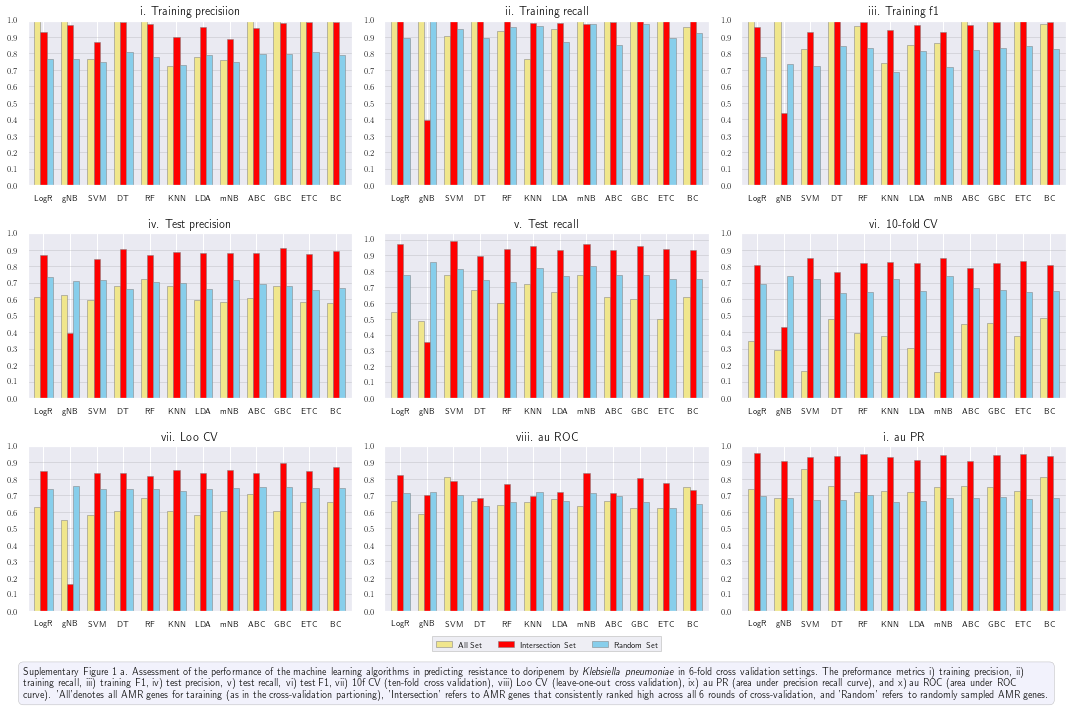

All Set Results ertapenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.730,0.670,0.672,0.556,0.801,0.820,0.700
1,gNB,1.000,1.000,1.000,0.590,0.601,0.575,0.407,0.582,0.696,0.633
2,SVM,0.829,0.702,0.757,0.662,0.580,0.597,0.205,0.762,0.796,0.600
3,DT,1.000,1.000,1.000,0.829,0.688,0.745,0.551,0.778,0.836,0.844
4,RF,0.987,0.978,0.982,0.748,0.598,0.646,0.487,0.798,0.804,0.667
5,KNN,0.862,0.782,0.817,0.707,0.601,0.633,0.534,0.796,0.811,0.644
6,LDA,0.836,0.844,0.840,0.643,0.619,0.624,0.282,0.759,0.801,0.600
7,mNB,0.821,0.795,0.807,0.688,0.619,0.636,0.196,0.688,0.743,0.656
8,ABC,1.000,1.000,1.000,0.800,0.676,0.705,0.480,0.774,0.755,0.756
9,GBC,1.000,1.000,1.000,0.776,0.669,0.713,0.549,0.824,0.838,0.811


Intersection Set Results ertapenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.929,0.987,0.957,0.905,0.964,0.933,0.862,0.917,0.975,0.879
1,gNB,1.000,0.616,0.762,0.985,0.588,0.732,0.669,0.910,0.978,0.640
2,SVM,0.898,1.000,0.946,0.890,0.995,0.939,0.872,0.907,0.975,0.895
3,DT,0.994,0.987,0.990,0.923,0.912,0.917,0.842,0.793,0.951,0.841
4,RF,0.976,0.995,0.986,0.935,0.949,0.942,0.858,0.880,0.965,0.870
5,KNN,0.931,0.953,0.941,0.924,0.908,0.915,0.842,0.852,0.959,0.858
6,LDA,0.959,0.982,0.970,0.902,0.938,0.919,0.852,0.890,0.967,0.866
7,mNB,0.918,0.924,0.921,0.917,0.897,0.906,0.832,0.858,0.964,0.837
8,ABC,0.976,0.985,0.980,0.914,0.928,0.920,0.848,0.917,0.979,0.858
9,GBC,0.985,0.991,0.988,0.923,0.964,0.942,0.853,0.926,0.980,0.883


Random Set Results ertapenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.742,0.778,0.760,0.664,0.704,0.616,0.655,0.707,0.631,0.673
1,gNB,0.703,1.000,0.674,0.563,0.593,0.498,0.585,0.623,0.539,0.563
2,SVM,0.688,0.644,0.710,0.641,0.603,0.611,0.604,0.648,0.601,0.638
3,DT,0.842,0.916,0.872,0.718,0.771,0.671,0.686,0.778,0.686,0.718
4,RF,0.814,0.906,0.850,0.719,0.759,0.660,0.680,0.764,0.677,0.717
5,KNN,0.724,0.822,0.733,0.673,0.724,0.605,0.659,0.701,0.658,0.662
6,LDA,0.790,0.849,0.810,0.705,0.754,0.632,0.677,0.745,0.670,0.694
7,mNB,0.697,0.715,0.717,0.643,0.646,0.623,0.623,0.666,0.615,0.649
8,ABC,0.773,0.853,0.796,0.694,0.739,0.620,0.667,0.733,0.659,0.689
9,GBC,0.818,0.907,0.846,0.700,0.770,0.650,0.685,0.766,0.670,0.712


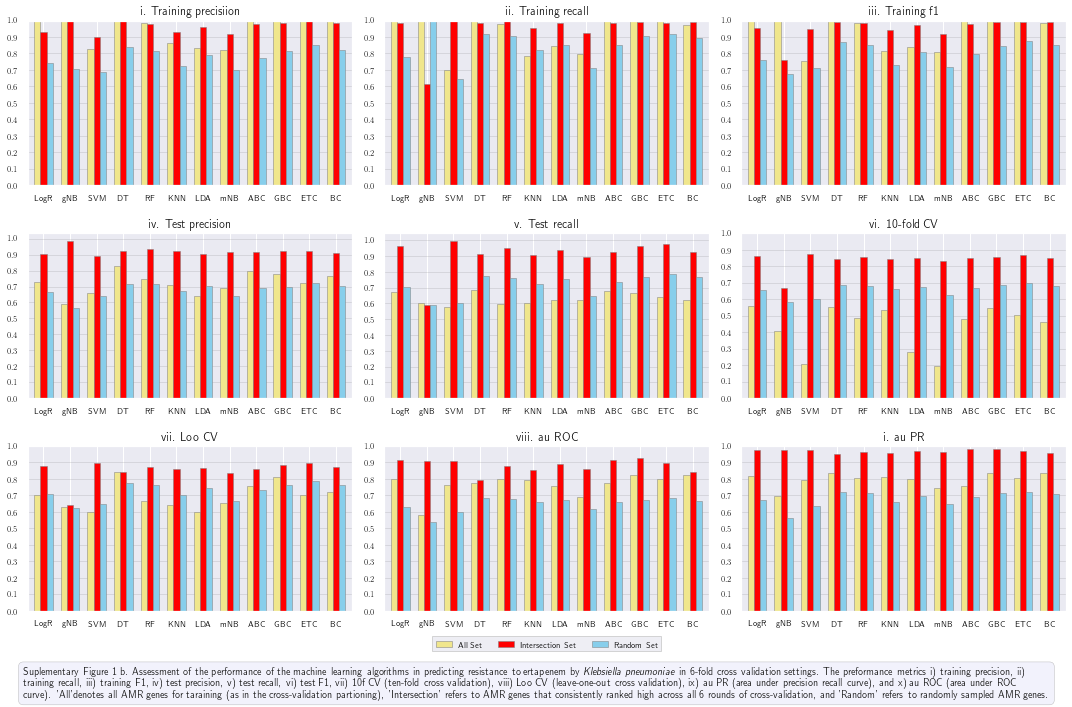

All Set Results imipenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.671,0.683,0.667,0.445,0.770,0.818,0.618
1,gNB,1.000,1.000,1.000,0.720,0.623,0.651,0.363,0.663,0.764,0.658
2,SVM,0.853,0.637,0.728,0.683,0.500,0.570,0.225,0.440,0.569,0.618
3,DT,1.000,1.000,1.000,0.720,0.663,0.674,0.505,0.694,0.776,0.605
4,RF,0.995,0.958,0.976,0.755,0.576,0.634,0.418,0.730,0.791,0.697
5,KNN,0.818,0.789,0.802,0.614,0.583,0.592,0.432,0.693,0.758,0.592
6,LDA,0.797,0.805,0.801,0.590,0.579,0.580,0.289,0.703,0.770,0.526
7,mNB,0.774,0.768,0.771,0.620,0.659,0.634,0.209,0.636,0.712,0.579
8,ABC,1.000,1.000,1.000,0.742,0.730,0.729,0.542,0.774,0.795,0.658
9,GBC,1.000,1.000,1.000,0.842,0.762,0.797,0.558,0.882,0.902,0.737


Intersection Set Results imipenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.936,0.964,0.950,0.884,0.924,0.902,0.786,0.899,0.970,0.842
1,gNB,1.000,0.629,0.768,0.937,0.607,0.730,0.623,0.811,0.945,0.612
2,SVM,0.885,0.987,0.933,0.843,0.952,0.893,0.752,0.866,0.962,0.825
3,DT,0.987,0.976,0.982,0.895,0.868,0.879,0.751,0.740,0.931,0.803
4,RF,0.975,0.979,0.977,0.896,0.903,0.897,0.758,0.860,0.959,0.814
5,KNN,0.944,0.859,0.900,0.930,0.806,0.862,0.692,0.834,0.956,0.787
6,LDA,0.959,0.956,0.957,0.904,0.875,0.888,0.743,0.848,0.952,0.836
7,mNB,0.932,0.774,0.845,0.908,0.758,0.825,0.711,0.843,0.955,0.743
8,ABC,0.956,0.963,0.959,0.897,0.876,0.885,0.777,0.843,0.950,0.842
9,GBC,0.969,0.983,0.976,0.895,0.917,0.905,0.775,0.878,0.962,0.847


Random Set Results imipenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.740,0.779,0.755,0.655,0.701,0.641,0.653,0.704,0.614,0.669
1,gNB,0.707,1.000,0.657,0.560,0.677,0.514,0.625,0.647,0.551,0.567
2,SVM,0.699,0.642,0.699,0.641,0.640,0.631,0.624,0.658,0.618,0.628
3,DT,0.824,0.837,0.845,0.670,0.766,0.623,0.679,0.763,0.654,0.700
4,RF,0.788,0.842,0.821,0.651,0.746,0.626,0.667,0.744,0.647,0.699
5,KNN,0.725,0.800,0.711,0.625,0.746,0.608,0.666,0.698,0.618,0.639
6,LDA,0.780,0.847,0.794,0.669,0.748,0.613,0.666,0.733,0.628,0.677
7,mNB,0.706,0.684,0.702,0.627,0.700,0.628,0.643,0.677,0.619,0.633
8,ABC,0.768,0.815,0.787,0.660,0.733,0.616,0.653,0.722,0.630,0.668
9,GBC,0.802,0.890,0.828,0.677,0.763,0.634,0.674,0.753,0.643,0.696


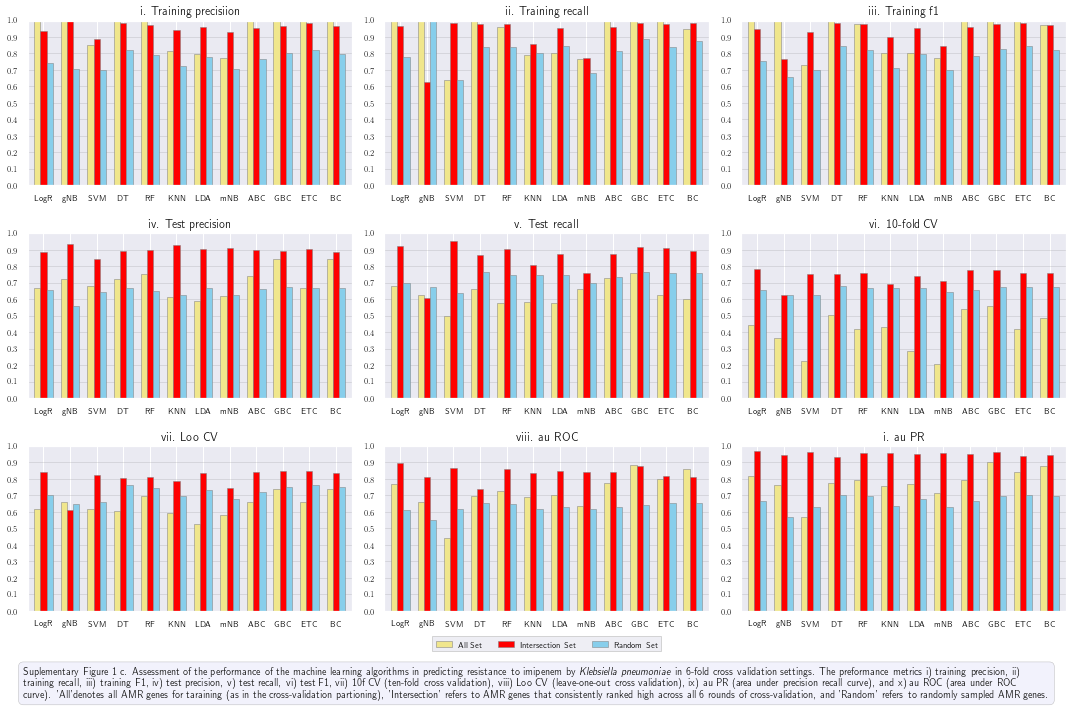

All Set Results meropenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.849,0.755,0.796,0.647,0.866,0.868,0.804
1,gNB,1.000,1.000,1.000,0.835,0.766,0.798,0.459,0.802,0.859,0.783
2,SVM,0.860,0.760,0.806,0.779,0.709,0.741,0.268,0.851,0.857,0.717
3,DT,1.000,1.000,1.000,0.813,0.780,0.784,0.651,0.787,0.851,0.804
4,RF,0.988,0.939,0.963,0.816,0.738,0.773,0.576,0.820,0.836,0.797
5,KNN,0.853,0.733,0.788,0.762,0.751,0.756,0.597,0.820,0.844,0.739
6,LDA,0.843,0.838,0.840,0.772,0.781,0.775,0.532,0.842,0.855,0.739
7,mNB,0.795,0.815,0.804,0.749,0.740,0.743,0.335,0.778,0.811,0.732
8,ABC,1.000,1.000,1.000,0.779,0.841,0.808,0.641,0.843,0.830,0.804
9,GBC,1.000,1.000,1.000,0.914,0.812,0.856,0.638,0.896,0.909,0.841


Intersection Set Results meropenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.969,0.972,0.971,0.907,0.899,0.902,0.840,0.928,0.963,0.867
1,gNB,1.000,0.501,0.665,0.944,0.470,0.624,0.604,0.895,0.943,0.610
2,SVM,0.922,0.967,0.944,0.864,0.919,0.889,0.824,0.905,0.950,0.839
3,DT,0.993,0.984,0.989,0.862,0.785,0.819,0.788,0.746,0.894,0.839
4,RF,0.980,0.991,0.985,0.863,0.859,0.860,0.807,0.875,0.936,0.844
5,KNN,0.908,0.860,0.884,0.872,0.805,0.836,0.777,0.850,0.925,0.789
6,LDA,0.980,0.989,0.985,0.866,0.826,0.843,0.756,0.826,0.891,0.803
7,mNB,0.874,0.832,0.853,0.872,0.812,0.840,0.786,0.870,0.936,0.784
8,ABC,0.971,0.972,0.971,0.903,0.906,0.903,0.839,0.901,0.947,0.876
9,GBC,0.987,0.988,0.987,0.881,0.892,0.885,0.815,0.893,0.924,0.853


Random Set Results meropenem Klebsiella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.783,0.800,0.786,0.702,0.760,0.717,0.725,0.756,0.708,0.728
1,gNB,0.714,0.684,0.669,0.587,0.619,0.552,0.613,0.637,0.558,0.573
2,SVM,0.754,0.670,0.759,0.703,0.698,0.719,0.695,0.722,0.697,0.706
3,DT,0.847,0.873,0.871,0.762,0.801,0.724,0.732,0.801,0.749,0.756
4,RF,0.829,0.864,0.854,0.749,0.787,0.714,0.728,0.790,0.724,0.754
5,KNN,0.762,0.823,0.755,0.712,0.781,0.702,0.728,0.748,0.713,0.711
6,LDA,0.819,0.829,0.823,0.734,0.799,0.731,0.739,0.784,0.742,0.740
7,mNB,0.739,0.774,0.741,0.703,0.732,0.684,0.700,0.722,0.698,0.699
8,ABC,0.810,0.809,0.817,0.740,0.791,0.735,0.734,0.778,0.743,0.738
9,GBC,0.832,0.841,0.847,0.762,0.800,0.732,0.740,0.795,0.753,0.754


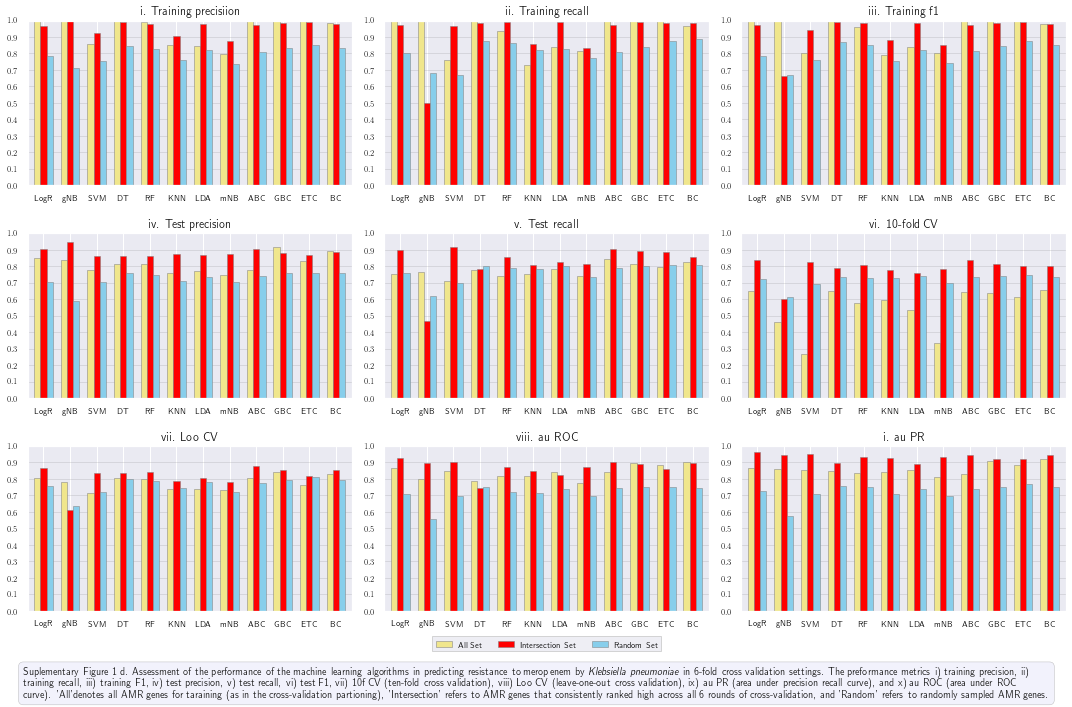

In [36]:

#All set, Intersection set and Random set performance for Klebsiella pneumoniae

#Dictionary of antibiotics
antb_SN = {'doripenem': '1 a', 'ertapenem': '1 b', 'imipenem': '1 c', 'meropenem': '1 d'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Klebsiella pneumoniae
    bacteria = 'Klebsiella'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Klebsiella pneumoniae}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    susceptible = data_.loc[data_[antb] == 0]
    no_of_sus = len(susceptible.index)
    
    #Select equal number of resistant dataset
    resistant = data_.loc[data_[antb] == 1].sample(n=no_of_sus, random_state=42)
    
   #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

All Set Results doripenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.722,0.556,0.611,0.455,0.889,0.854,0.714
1,gNB,1.000,1.000,1.000,0.778,0.639,0.689,0.385,0.722,0.796,0.714
2,SVM,0.882,0.683,0.644,0.400,0.500,0.406,0.160,0.167,0.341,0.036
3,DT,1.000,1.000,1.000,0.767,0.667,0.681,0.451,0.750,0.871,0.679
4,RF,1.000,0.943,0.970,0.750,0.528,0.606,0.415,0.812,0.842,0.679
5,KNN,0.668,0.672,0.667,0.597,0.556,0.515,0.400,0.576,0.636,0.571
6,LDA,0.768,0.738,0.750,0.736,0.583,0.600,0.232,0.750,0.735,0.464
7,mNB,0.916,1.000,0.955,0.750,0.611,0.589,0.201,0.764,0.812,0.571
8,ABC,1.000,1.000,1.000,0.792,0.694,0.721,0.444,0.833,0.830,0.821
9,GBC,1.000,1.000,1.000,0.778,0.500,0.584,0.423,0.736,0.781,0.821


Intersection Set Results doripenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,1.000,0.750,0.828,0.869,1.000,1.000,0.925
1,gNB,0.986,1.000,0.993,0.958,0.861,0.887,0.938,0.970,0.949,0.925
2,SVM,1.000,1.000,1.000,1.000,0.833,0.883,0.847,1.000,1.000,0.900
3,DT,1.000,1.000,1.000,0.750,0.639,0.673,0.808,0.736,0.758,0.800
4,RF,1.000,1.000,1.000,1.000,0.806,0.878,0.854,0.972,0.975,0.900
5,KNN,0.985,0.771,0.861,0.917,0.750,0.811,0.846,0.951,0.952,0.875
6,LDA,1.000,1.000,1.000,0.861,0.750,0.739,0.786,0.951,0.940,0.800
7,mNB,0.973,1.000,0.986,0.875,0.917,0.893,0.946,0.970,0.949,0.925
8,ABC,1.000,1.000,1.000,0.861,0.861,0.850,0.860,0.979,0.965,0.925
9,GBC,1.000,1.000,1.000,0.694,0.694,0.673,0.817,0.847,0.838,0.850


Random Set Results doripenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.839,0.986,0.842,0.716,0.820,0.664,0.704,0.781,0.699,0.697
1,gNB,0.801,1.000,0.797,0.686,0.746,0.650,0.671,0.736,0.669,0.664
2,SVM,0.726,0.822,0.697,0.440,0.672,0.436,0.623,0.662,0.403,0.590
3,DT,0.906,1.000,0.905,0.767,0.853,0.694,0.743,0.829,0.754,0.736
4,RF,0.861,0.971,0.886,0.696,0.801,0.627,0.699,0.794,0.702,0.722
5,KNN,0.701,0.886,0.644,0.573,0.790,0.543,0.669,0.679,0.615,0.583
6,LDA,0.832,0.826,0.870,0.675,0.774,0.584,0.665,0.769,0.649,0.702
7,mNB,0.795,1.000,0.782,0.605,0.776,0.549,0.665,0.732,0.585,0.640
8,ABC,0.885,1.000,0.891,0.749,0.849,0.729,0.727,0.816,0.762,0.724
9,GBC,0.890,1.000,0.893,0.734,0.858,0.725,0.734,0.821,0.751,0.728


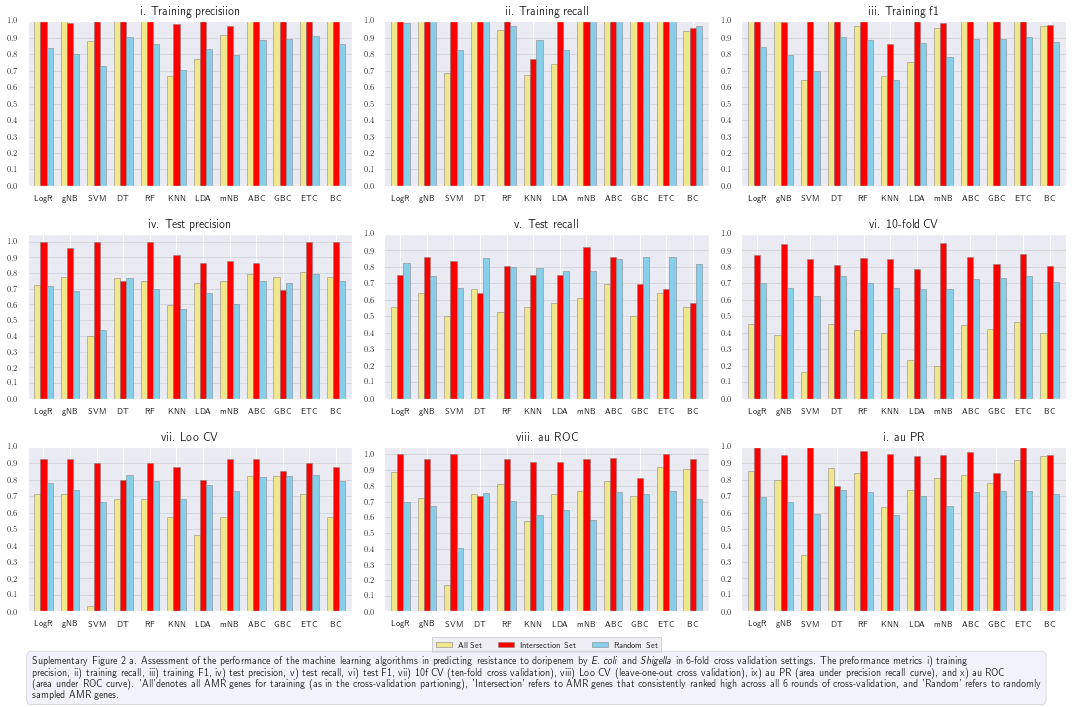

All Set Results ertapenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.911,0.822,0.850,0.580,0.970,0.971,0.844
1,gNB,1.000,1.000,1.000,0.715,0.939,0.809,0.501,0.781,0.843,0.781
2,SVM,0.798,0.813,0.805,0.732,0.828,0.761,0.311,0.862,0.870,0.750
3,DT,1.000,1.000,1.000,0.781,0.756,0.765,0.627,0.767,0.831,0.766
4,RF,1.000,0.994,0.997,0.836,0.733,0.752,0.560,0.884,0.897,0.750
5,KNN,0.841,0.794,0.816,0.717,0.611,0.641,0.555,0.807,0.819,0.734
6,LDA,0.870,0.875,0.872,0.707,0.672,0.669,0.527,0.871,0.855,0.734
7,mNB,0.856,0.813,0.833,0.740,0.794,0.752,0.307,0.818,0.853,0.766
8,ABC,1.000,1.000,1.000,0.815,0.878,0.837,0.536,0.854,0.840,0.891
9,GBC,1.000,1.000,1.000,0.738,0.761,0.739,0.620,0.856,0.881,0.844


Intersection Set Results ertapenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,0.956,0.977,0.958,0.694,0.786,0.899,0.967,0.909,0.922
1,gNB,0.900,0.894,0.872,0.885,0.750,0.780,0.899,0.907,0.886,0.922
2,SVM,1.000,0.907,0.951,0.944,0.594,0.719,0.865,0.979,0.936,0.922
3,DT,1.000,1.000,1.000,0.958,0.722,0.818,0.930,0.857,0.870,0.941
4,RF,1.000,0.975,0.987,1.000,0.656,0.786,0.867,0.909,0.880,0.908
5,KNN,0.900,0.657,0.758,0.814,0.628,0.701,0.844,0.916,0.828,0.882
6,LDA,1.000,1.000,1.000,0.869,0.789,0.820,0.905,0.971,0.918,0.928
7,mNB,0.775,0.900,0.832,0.782,0.856,0.807,0.904,0.957,0.897,0.908
8,ABC,1.000,1.000,1.000,1.000,0.761,0.846,0.935,0.974,0.936,0.941
9,GBC,1.000,1.000,1.000,0.930,0.822,0.866,0.945,0.970,0.925,0.961


Random Set Results ertapenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.838,0.844,0.844,0.771,0.792,0.742,0.753,0.797,0.755,0.760
1,gNB,0.787,0.625,0.802,0.641,0.576,0.585,0.630,0.692,0.572,0.676
2,SVM,0.785,0.788,0.778,0.753,0.767,0.729,0.739,0.760,0.727,0.729
3,DT,0.898,0.926,0.919,0.793,0.835,0.724,0.761,0.839,0.753,0.783
4,RF,0.891,0.963,0.911,0.815,0.835,0.730,0.761,0.836,0.770,0.782
5,KNN,0.767,0.880,0.761,0.725,0.772,0.683,0.725,0.748,0.705,0.713
6,LDA,0.867,0.913,0.893,0.784,0.812,0.711,0.738,0.815,0.734,0.765
7,mNB,0.772,0.730,0.788,0.726,0.697,0.673,0.691,0.733,0.670,0.717
8,ABC,0.863,0.907,0.897,0.807,0.811,0.733,0.752,0.823,0.743,0.789
9,GBC,0.897,0.913,0.915,0.798,0.849,0.741,0.775,0.845,0.767,0.791


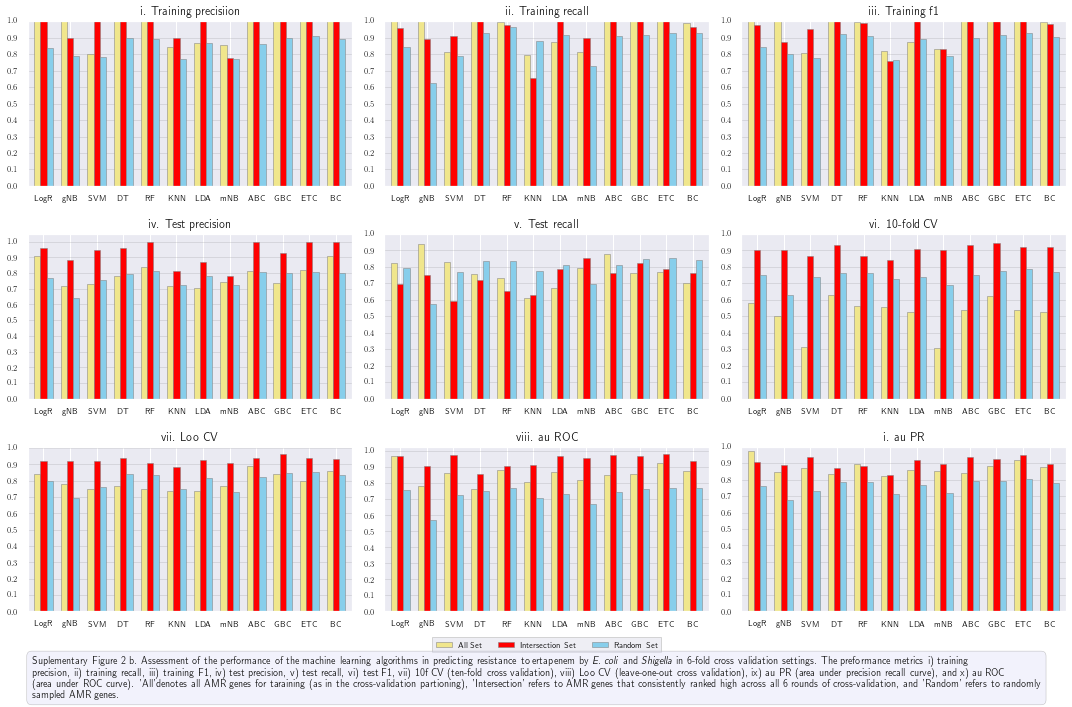

All Set Results imipenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.850,0.708,0.713,0.435,0.934,0.936,0.750
1,gNB,1.000,1.000,1.000,0.792,0.778,0.774,0.383,0.785,0.841,0.773
2,SVM,0.882,0.853,0.862,0.753,0.694,0.694,0.171,0.587,0.695,0.614
3,DT,1.000,1.000,1.000,1.000,0.958,0.976,0.636,0.979,0.990,1.000
4,RF,1.000,0.973,0.986,0.700,0.556,0.574,0.412,0.769,0.816,0.773
5,KNN,0.817,0.708,0.756,0.597,0.570,0.577,0.305,0.804,0.843,0.682
6,LDA,0.784,0.754,0.769,0.742,0.583,0.564,0.267,0.746,0.728,0.591
7,mNB,0.942,0.872,0.904,0.767,0.736,0.724,0.236,0.783,0.833,0.682
8,ABC,1.000,1.000,1.000,1.000,0.958,0.976,0.733,1.000,1.000,0.977
9,GBC,1.000,1.000,1.000,1.000,0.958,0.976,0.604,1.000,1.000,0.977


Intersection Set Results imipenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,1.000,0.875,0.921,0.944,1.000,1.000,0.979
1,gNB,0.991,1.000,0.995,0.869,1.000,0.924,0.946,0.973,0.935,0.969
2,SVM,1.000,1.000,1.000,0.925,0.958,0.940,0.935,0.987,0.930,0.979
3,DT,1.000,1.000,1.000,1.000,0.958,0.976,0.998,0.979,0.984,1.000
4,RF,1.000,0.982,0.991,0.967,0.833,0.858,0.950,1.000,1.000,0.969
5,KNN,0.978,0.746,0.844,0.800,0.597,0.669,0.869,0.917,0.937,0.918
6,LDA,1.000,1.000,1.000,0.911,0.833,0.854,0.904,0.906,0.895,0.979
7,mNB,0.949,1.000,0.973,0.911,1.000,0.948,0.980,0.997,0.991,0.969
8,ABC,1.000,1.000,1.000,1.000,0.958,0.976,0.990,1.000,1.000,0.990
9,GBC,1.000,1.000,1.000,1.000,0.958,0.976,0.990,1.000,1.000,0.990


Random Set Results imipenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.789,0.863,0.807,0.692,0.751,0.646,0.680,0.745,0.636,0.697
1,gNB,0.758,0.657,0.773,0.671,0.662,0.563,0.639,0.699,0.617,0.665
2,SVM,0.730,0.834,0.730,0.627,0.697,0.614,0.647,0.690,0.616,0.645
3,DT,0.843,0.936,0.889,0.716,0.774,0.632,0.674,0.780,0.594,0.721
4,RF,0.833,0.918,0.874,0.706,0.767,0.631,0.668,0.770,0.619,0.710
5,KNN,0.669,0.854,0.665,0.613,0.699,0.532,0.624,0.654,0.577,0.608
6,LDA,0.830,0.882,0.861,0.669,0.777,0.593,0.668,0.767,0.633,0.696
7,mNB,0.758,0.752,0.767,0.670,0.695,0.660,0.665,0.712,0.613,0.678
8,ABC,0.831,0.836,0.865,0.720,0.776,0.606,0.676,0.771,0.637,0.709
9,GBC,0.848,0.945,0.878,0.714,0.802,0.623,0.691,0.787,0.641,0.717


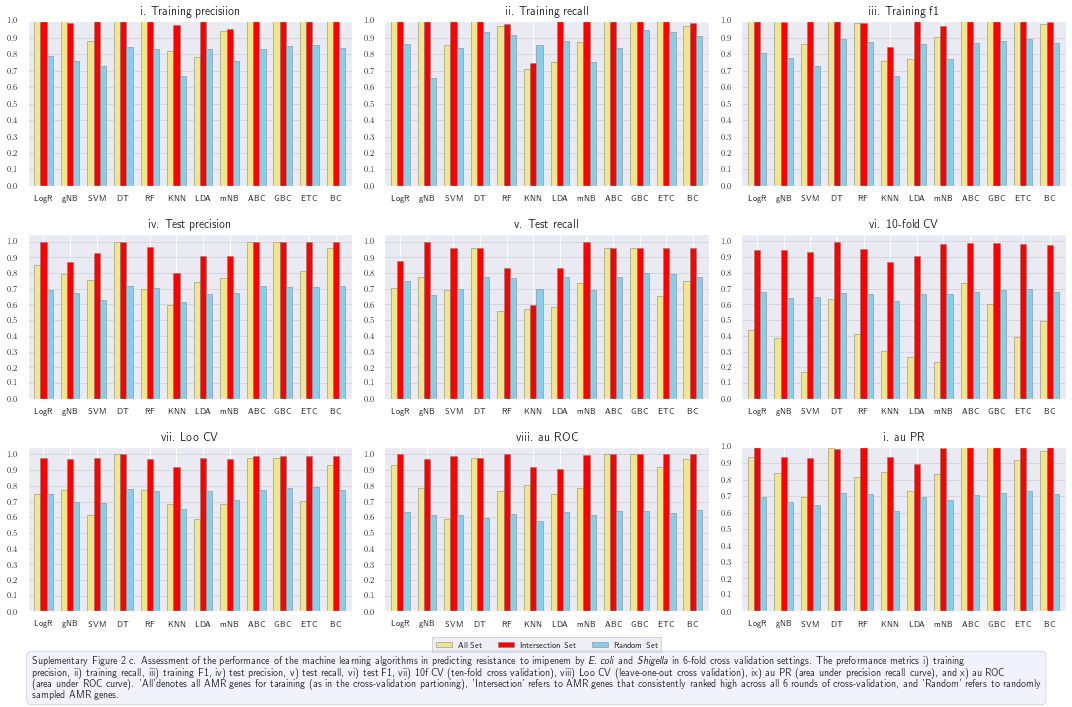

All Set Results meropenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.864,0.700,0.750,0.519,0.860,0.886,0.767
1,gNB,1.000,1.000,1.000,0.688,0.800,0.718,0.384,0.683,0.794,0.700
2,SVM,0.781,0.900,0.836,0.734,0.900,0.800,0.216,0.860,0.880,0.767
3,DT,1.000,1.000,1.000,0.817,0.667,0.729,0.555,0.750,0.825,0.667
4,RF,1.000,0.980,0.990,0.850,0.633,0.688,0.504,0.830,0.869,0.783
5,KNN,0.806,0.827,0.815,0.764,0.700,0.701,0.427,0.773,0.786,0.733
6,LDA,0.803,0.873,0.836,0.709,0.733,0.704,0.416,0.780,0.733,0.717
7,mNB,0.795,0.900,0.844,0.781,0.833,0.798,0.235,0.810,0.855,0.800
8,ABC,1.000,1.000,1.000,0.758,0.733,0.733,0.565,0.840,0.871,0.750
9,GBC,1.000,1.000,1.000,0.725,0.667,0.680,0.506,0.823,0.868,0.750


Intersection Set Results meropenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,0.800,0.889,1.000,0.767,0.856,0.922,0.956,0.900,0.954
1,gNB,0.841,0.820,0.783,0.826,0.700,0.692,0.818,0.817,0.777,0.901
2,SVM,1.000,0.700,0.823,1.000,0.633,0.773,0.903,0.946,0.875,0.927
3,DT,1.000,0.947,0.972,0.755,0.800,0.771,0.884,0.866,0.795,0.901
4,RF,0.986,0.913,0.948,0.875,0.700,0.773,0.893,0.914,0.840,0.921
5,KNN,0.942,0.713,0.810,0.925,0.633,0.738,0.846,0.907,0.852,0.901
6,LDA,1.000,0.853,0.920,0.812,0.633,0.660,0.874,0.928,0.817,0.921
7,mNB,0.814,0.800,0.805,0.803,0.800,0.776,0.872,0.931,0.863,0.894
8,ABC,1.000,0.947,0.972,0.806,0.767,0.775,0.895,0.930,0.898,0.907
9,GBC,1.000,0.947,0.972,0.925,0.733,0.809,0.888,0.943,0.894,0.907


Random Set Results meropenem EcS


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.818,0.853,0.831,0.782,0.799,0.735,0.747,0.791,0.754,0.758
1,gNB,0.774,0.507,0.800,0.605,0.537,0.545,0.590,0.669,0.554,0.651
2,SVM,0.776,0.900,0.775,0.781,0.796,0.729,0.753,0.769,0.747,0.745
3,DT,0.865,0.947,0.910,0.810,0.795,0.728,0.719,0.811,0.750,0.768
4,RF,0.865,0.933,0.899,0.808,0.808,0.735,0.726,0.812,0.764,0.761
5,KNN,0.768,0.900,0.755,0.772,0.803,0.742,0.760,0.765,0.756,0.737
6,LDA,0.836,0.900,0.874,0.734,0.783,0.695,0.703,0.788,0.715,0.742
7,mNB,0.778,0.753,0.797,0.757,0.731,0.680,0.709,0.749,0.702,0.733
8,ABC,0.852,0.880,0.882,0.766,0.803,0.722,0.723,0.802,0.732,0.753
9,GBC,0.860,0.953,0.903,0.794,0.807,0.713,0.730,0.815,0.744,0.775


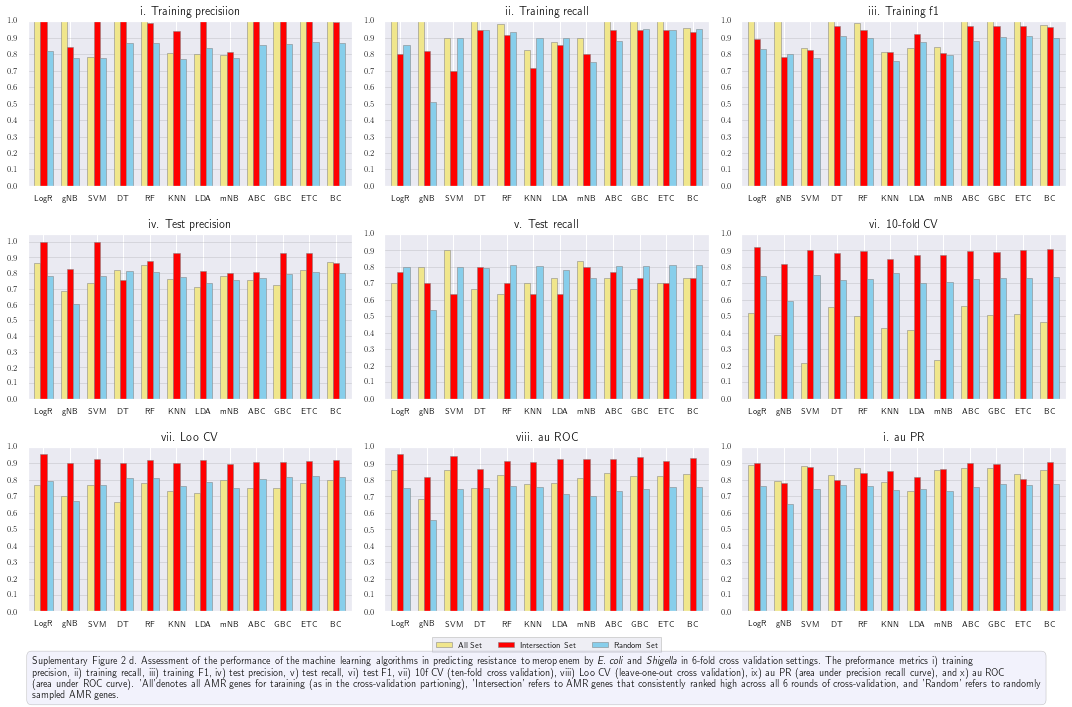

In [38]:
#All set, Intersection set and Random set performance for E. coli and Shigella

#Dictionary of antibiotics
antb_SN = {'doripenem': '2 a', 'ertapenem': '2 b', 'imipenem': '2 c', 'meropenem': '2 d'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Klebsiella pneumoniae
    bacteria = 'EcS'
    
    #Italicized full name bacteria for fig output
    it1 = r"\textit{E. coli}"
    it2 = r"\textit{Shigella}"
    italic_name = it1 + ' and ' + it2
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    resistant = data_.loc[data_[antb] == 1]
    no_of_res = len(resistant.index)
    
    #Select equal number of resistant dataset
    susceptible = data_.loc[data_[antb] == 0].sample(n=no_of_res, random_state=42)
    
   #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

All Set Results imipenem Pseudomonas


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.806,0.607,0.669,0.266,0.747,0.788,0.659
1,gNB,1.000,1.000,1.000,0.505,0.635,0.561,0.245,0.502,0.661,0.488
2,SVM,1.000,0.478,0.645,0.833,0.290,0.422,0.174,0.329,0.433,0.598
3,DT,1.000,1.000,1.000,0.772,0.702,0.731,0.358,0.752,0.811,0.793
4,RF,0.990,0.956,0.972,0.653,0.460,0.536,0.320,0.702,0.702,0.610
5,KNN,0.817,0.561,0.661,0.762,0.385,0.462,0.326,0.655,0.698,0.598
6,LDA,0.762,0.673,0.714,0.662,0.488,0.555,0.251,0.621,0.685,0.598
7,mNB,0.960,0.600,0.738,0.697,0.413,0.507,0.261,0.667,0.724,0.622
8,ABC,1.000,1.000,1.000,0.698,0.484,0.566,0.404,0.698,0.736,0.622
9,GBC,1.000,1.000,1.000,0.858,0.607,0.702,0.404,0.886,0.893,0.780


Intersection Set Results imipenem Pseudomonas


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.955,0.970,0.962,0.829,0.824,0.824,0.695,0.851,0.921,0.773
1,gNB,1.000,0.631,0.773,0.844,0.627,0.712,0.609,0.750,0.885,0.621
2,SVM,0.921,0.917,0.918,0.840,0.835,0.835,0.645,0.859,0.927,0.765
3,DT,1.000,1.000,1.000,0.785,0.746,0.758,0.662,0.643,0.853,0.667
4,RF,0.995,0.976,0.986,0.870,0.857,0.860,0.705,0.845,0.917,0.811
5,KNN,0.932,0.774,0.845,0.898,0.703,0.778,0.704,0.841,0.926,0.727
6,LDA,0.996,0.998,0.996,0.773,0.736,0.746,0.583,0.668,0.820,0.644
7,mNB,0.923,0.732,0.816,0.899,0.715,0.791,0.712,0.848,0.931,0.735
8,ABC,0.989,0.989,0.989,0.843,0.835,0.833,0.699,0.787,0.889,0.720
9,GBC,1.000,1.000,1.000,0.854,0.880,0.865,0.682,0.841,0.924,0.780


Random Set Results imipenem Pseudomonas


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.750,0.688,0.784,0.637,0.676,0.567,0.610,0.693,0.602,0.649
1,gNB,0.736,0.556,0.747,0.588,0.541,0.519,0.545,0.629,0.516,0.580
2,SVM,0.709,0.292,0.715,0.566,0.523,0.530,0.557,0.617,0.515,0.588
3,DT,0.829,0.902,0.894,0.673,0.737,0.537,0.620,0.754,0.581,0.690
4,RF,0.805,0.859,0.859,0.666,0.718,0.572,0.607,0.730,0.592,0.664
5,KNN,0.690,0.761,0.694,0.570,0.648,0.555,0.586,0.642,0.562,0.589
6,LDA,0.798,0.790,0.850,0.639,0.718,0.538,0.609,0.727,0.587,0.664
7,mNB,0.719,0.414,0.741,0.588,0.556,0.556,0.564,0.636,0.532,0.608
8,ABC,0.794,0.790,0.844,0.642,0.714,0.556,0.608,0.724,0.592,0.661
9,GBC,0.818,0.766,0.869,0.634,0.732,0.541,0.624,0.744,0.584,0.678


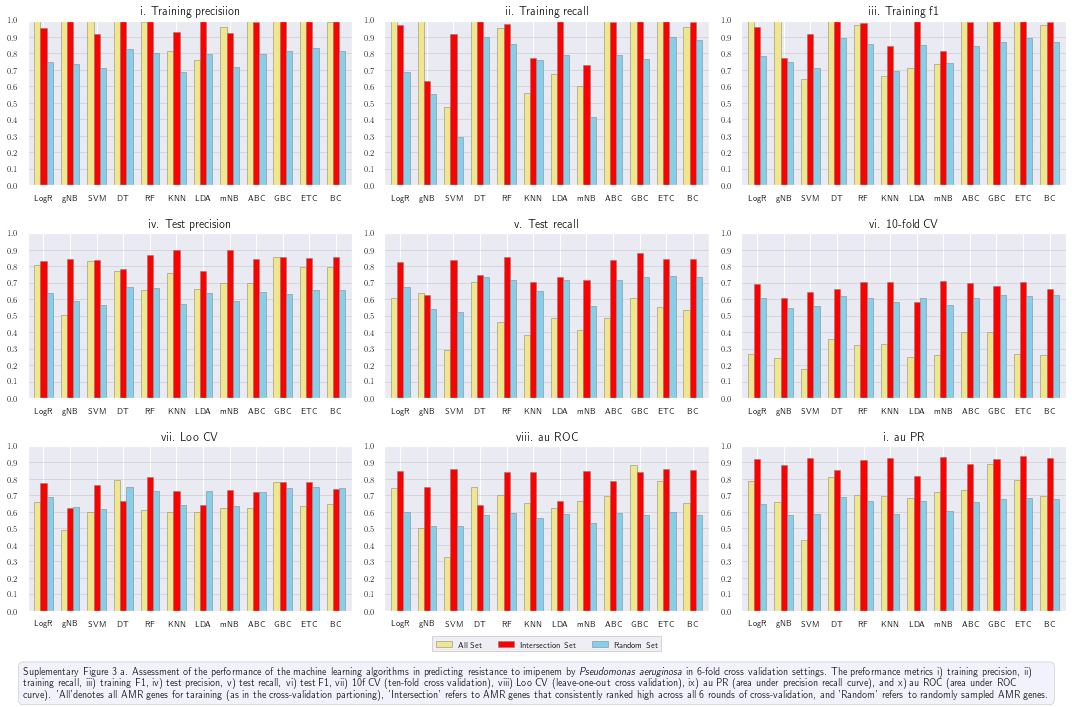

All Set Results meropenem Pseudomonas


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.726,0.583,0.625,0.335,0.708,0.749,0.656
1,gNB,1.000,1.000,1.000,0.592,0.812,0.678,0.245,0.625,0.750,0.615
2,SVM,0.968,0.608,0.746,0.861,0.438,0.529,0.190,0.754,0.794,0.635
3,DT,1.000,1.000,1.000,0.621,0.583,0.562,0.407,0.594,0.706,0.542
4,RF,1.000,0.942,0.969,0.845,0.542,0.628,0.301,0.725,0.795,0.635
5,KNN,0.879,0.638,0.737,0.744,0.500,0.579,0.347,0.715,0.731,0.635
6,LDA,0.827,0.771,0.797,0.833,0.542,0.621,0.243,0.721,0.769,0.677
7,mNB,0.964,0.646,0.773,0.847,0.438,0.504,0.245,0.706,0.758,0.646
8,ABC,1.000,1.000,1.000,0.707,0.688,0.695,0.361,0.701,0.740,0.615
9,GBC,1.000,1.000,1.000,0.612,0.604,0.602,0.324,0.721,0.746,0.646


Intersection Set Results meropenem Pseudomonas


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.981,0.967,0.974,0.814,0.845,0.826,0.726,0.868,0.920,0.795
1,gNB,1.000,0.719,0.836,0.943,0.690,0.784,0.733,0.897,0.945,0.773
2,SVM,0.964,0.957,0.960,0.864,0.893,0.876,0.771,0.892,0.936,0.841
3,DT,1.000,1.000,1.000,0.807,0.786,0.795,0.662,0.726,0.865,0.689
4,RF,1.000,0.988,0.994,0.869,0.786,0.823,0.698,0.856,0.918,0.803
5,KNN,0.942,0.728,0.821,0.900,0.631,0.738,0.680,0.819,0.905,0.735
6,LDA,0.998,1.000,0.999,0.772,0.643,0.696,0.579,0.651,0.791,0.652
7,mNB,0.943,0.824,0.880,0.877,0.774,0.818,0.762,0.872,0.932,0.795
8,ABC,0.995,0.995,0.995,0.816,0.786,0.795,0.702,0.802,0.877,0.750
9,GBC,1.000,1.000,1.000,0.801,0.822,0.810,0.702,0.842,0.905,0.765


Random Set Results meropenem Pseudomonas


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.777,0.692,0.804,0.663,0.703,0.642,0.661,0.728,0.643,0.694
1,gNB,0.778,0.550,0.786,0.613,0.512,0.592,0.583,0.656,0.547,0.629
2,SVM,0.752,0.483,0.759,0.641,0.603,0.656,0.626,0.678,0.585,0.653
3,DT,0.852,0.858,0.906,0.707,0.775,0.612,0.670,0.786,0.654,0.727
4,RF,0.842,0.829,0.890,0.710,0.764,0.634,0.675,0.780,0.659,0.728
5,KNN,0.702,0.954,0.713,0.632,0.691,0.575,0.620,0.670,0.588,0.625
6,LDA,0.800,0.775,0.846,0.659,0.725,0.613,0.630,0.736,0.628,0.679
7,mNB,0.750,0.538,0.760,0.653,0.590,0.661,0.626,0.675,0.598,0.658
8,ABC,0.809,0.796,0.848,0.675,0.745,0.618,0.657,0.751,0.644,0.698
9,GBC,0.839,0.742,0.885,0.698,0.757,0.629,0.675,0.776,0.655,0.726


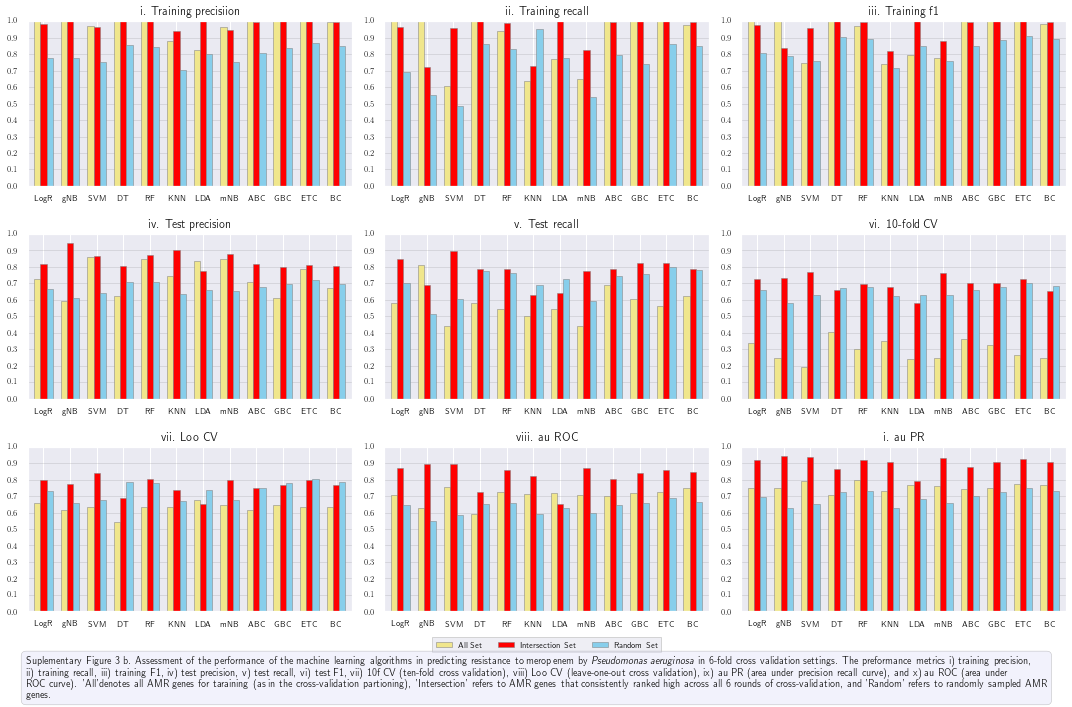

In [41]:
#All set, Intersection set and Random set performance for Pseudomonas aeruginosa

#Dictionary of antibiotics
antb_SN = {'imipenem': '3 a', 'meropenem': '3 b'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Pseudomonas aeruginosa
    bacteria = 'Pseudomonas'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Pseudomonas aeruginosa}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    susceptible = data_.loc[data_[antb] == 0]
    no_of= len(susceptible.index)
    
    #Select equal number of resistant dataset
    resistant = data_.loc[data_[antb] == 1].sample(n=no_of, random_state=42)
    
   #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

All Set Results imipenem Enterobacter


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.917,0.750,0.778,0.507,1.000,1.000,0.818
1,gNB,1.000,1.000,1.000,0.833,0.917,0.828,0.497,0.833,0.896,0.818
2,SVM,0.914,1.000,0.953,0.778,0.917,0.795,0.259,0.458,0.611,0.727
3,DT,1.000,1.000,1.000,0.833,0.667,0.722,0.476,0.750,0.826,0.773
4,RF,0.983,1.000,0.991,0.722,0.667,0.639,0.398,0.812,0.868,0.727
5,KNN,1.000,0.563,0.713,0.667,0.417,0.500,0.278,0.854,0.917,0.727
6,LDA,0.718,0.800,0.754,0.556,0.833,0.650,0.398,0.792,0.834,0.591
7,mNB,1.000,1.000,1.000,0.667,0.750,0.661,0.434,0.875,0.910,0.727
8,ABC,1.000,1.000,1.000,0.889,0.833,0.806,0.538,0.833,0.861,0.773
9,GBC,1.000,1.000,1.000,0.750,0.500,0.584,0.497,0.792,0.826,0.773


Intersection Set Results imipenem Enterobacter


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,1.000,0.917,0.944,0.906,1.000,1.000,0.931
1,gNB,1.000,1.000,1.000,0.944,1.000,0.967,0.959,0.972,0.972,0.966
2,SVM,1.000,1.000,1.000,1.000,0.917,0.944,0.853,1.000,1.000,0.897
3,DT,1.000,1.000,1.000,0.944,0.833,0.856,0.689,0.889,0.922,0.897
4,RF,1.000,1.000,1.000,0.861,0.833,0.828,0.814,0.958,0.951,0.897
5,KNN,0.883,0.965,0.922,0.861,0.917,0.883,0.881,0.958,0.951,0.897
6,LDA,1.000,0.982,0.990,0.833,0.583,0.667,0.878,0.944,0.931,0.862
7,mNB,0.902,1.000,0.948,0.889,1.000,0.933,0.944,1.000,1.000,0.931
8,ABC,1.000,1.000,1.000,1.000,0.833,0.889,0.789,0.944,0.931,0.897
9,GBC,1.000,1.000,1.000,0.944,0.833,0.856,0.678,0.972,0.979,0.931


Random Set Results imipenem Enterobacter


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.922,1.000,0.950,0.846,0.883,0.773,0.806,0.879,0.812,0.832
1,gNB,0.935,1.000,0.940,0.879,0.907,0.821,0.838,0.892,0.840,0.839
2,SVM,0.871,0.871,0.878,0.745,0.865,0.681,0.788,0.838,0.719,0.788
3,DT,0.903,1.000,0.936,0.797,0.854,0.755,0.756,0.848,0.749,0.788
4,RF,0.892,0.946,0.931,0.804,0.827,0.764,0.749,0.838,0.759,0.792
5,KNN,0.840,0.728,0.831,0.697,0.710,0.666,0.709,0.760,0.704,0.715
6,LDA,0.849,0.763,0.845,0.775,0.842,0.811,0.779,0.817,0.769,0.769
7,mNB,0.880,0.854,0.910,0.786,0.832,0.701,0.772,0.840,0.752,0.805
8,ABC,0.911,1.000,0.940,0.852,0.867,0.761,0.773,0.858,0.788,0.799
9,GBC,0.881,1.000,0.936,0.786,0.821,0.691,0.728,0.830,0.732,0.786


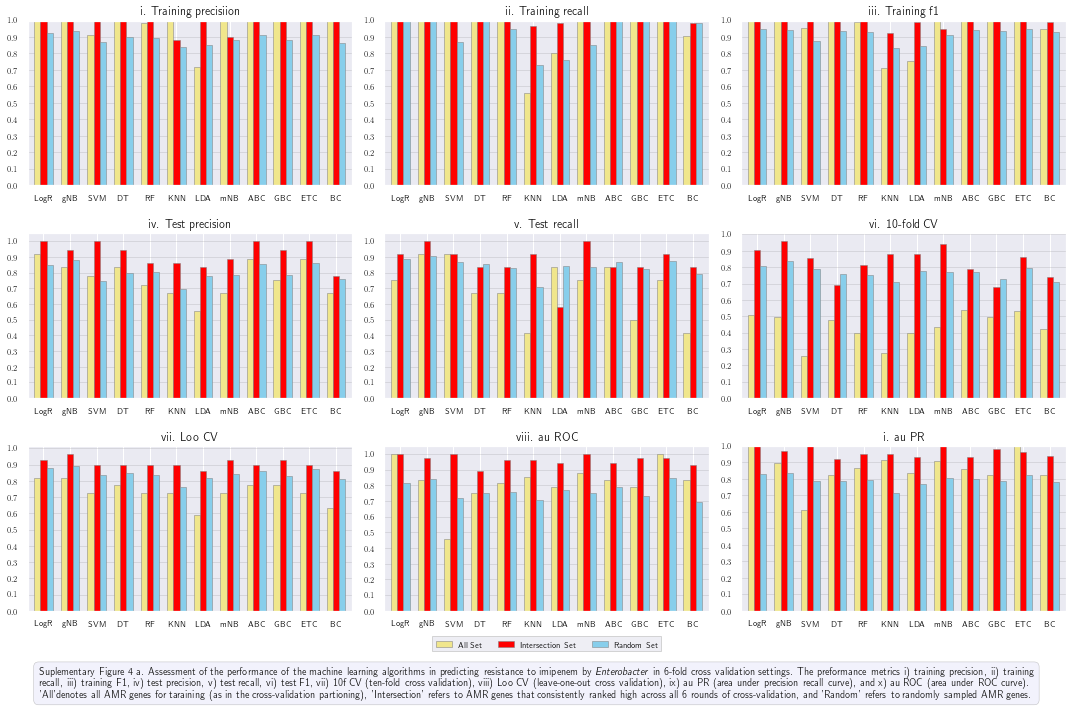

All Set Results meropenem Enterobacter


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.00,1.000,1.000,0.917,0.750,0.806,0.583,0.958,0.965,0.833
1,gNB,1.00,1.000,1.000,0.806,0.917,0.850,0.626,0.833,0.882,0.833
2,SVM,1.00,1.000,1.000,0.750,0.917,0.817,0.182,0.708,0.771,0.583
3,DT,1.00,1.000,1.000,0.583,0.333,0.417,0.594,0.583,0.708,0.500
4,RF,1.00,0.950,0.973,0.917,0.667,0.750,0.522,0.917,0.938,0.792
5,KNN,1.00,0.567,0.722,0.500,0.417,0.444,0.374,0.833,0.903,0.708
6,LDA,0.66,0.800,0.722,0.667,0.833,0.706,0.350,0.708,0.750,0.542
7,mNB,1.00,0.983,0.991,0.806,0.750,0.739,0.446,0.938,0.944,0.708
8,ABC,1.00,1.000,1.000,0.833,0.500,0.611,0.558,0.854,0.854,0.667
9,GBC,1.00,1.000,1.000,0.667,0.417,0.500,0.586,0.708,0.799,0.417


Intersection Set Results meropenem Enterobacter


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.861,0.833,0.828,0.878,0.979,0.965,0.882
1,gNB,1.000,1.000,1.000,0.834,1.000,0.900,0.906,0.930,0.916,0.912
2,SVM,1.000,1.000,1.000,0.861,0.833,0.828,0.850,0.958,0.931,0.882
3,DT,1.000,1.000,1.000,0.778,0.667,0.689,0.783,0.806,0.861,0.794
4,RF,1.000,0.967,0.982,0.861,0.667,0.717,0.825,0.938,0.868,0.853
5,KNN,0.819,0.750,0.783,0.833,0.750,0.778,0.861,0.906,0.875,0.853
6,LDA,0.954,1.000,0.976,0.917,0.833,0.861,0.864,0.979,0.965,0.882
7,mNB,0.854,0.967,0.906,0.889,0.917,0.878,0.900,0.958,0.931,0.882
8,ABC,1.000,1.000,1.000,0.917,0.750,0.806,0.839,0.958,0.972,0.912
9,GBC,1.000,1.000,1.000,0.556,0.583,0.567,0.806,0.792,0.802,0.882


Random Set Results meropenem Enterobacter


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.895,1.000,0.938,0.842,0.838,0.745,0.766,0.850,0.766,0.812
1,gNB,0.901,1.000,0.925,0.812,0.849,0.758,0.782,0.853,0.782,0.807
2,SVM,0.869,0.900,0.856,0.741,0.844,0.650,0.730,0.802,0.666,0.706
3,DT,0.897,1.000,0.934,0.831,0.846,0.738,0.746,0.841,0.757,0.781
4,RF,0.847,0.967,0.929,0.762,0.760,0.665,0.693,0.803,0.668,0.787
5,KNN,0.789,0.733,0.798,0.697,0.659,0.696,0.656,0.716,0.629,0.680
6,LDA,0.827,0.833,0.839,0.733,0.792,0.667,0.715,0.780,0.754,0.724
7,mNB,0.865,0.917,0.889,0.782,0.803,0.710,0.740,0.813,0.699,0.767
8,ABC,0.875,1.000,0.937,0.844,0.813,0.734,0.724,0.828,0.736,0.790
9,GBC,0.881,1.000,0.936,0.836,0.821,0.706,0.728,0.830,0.716,0.785


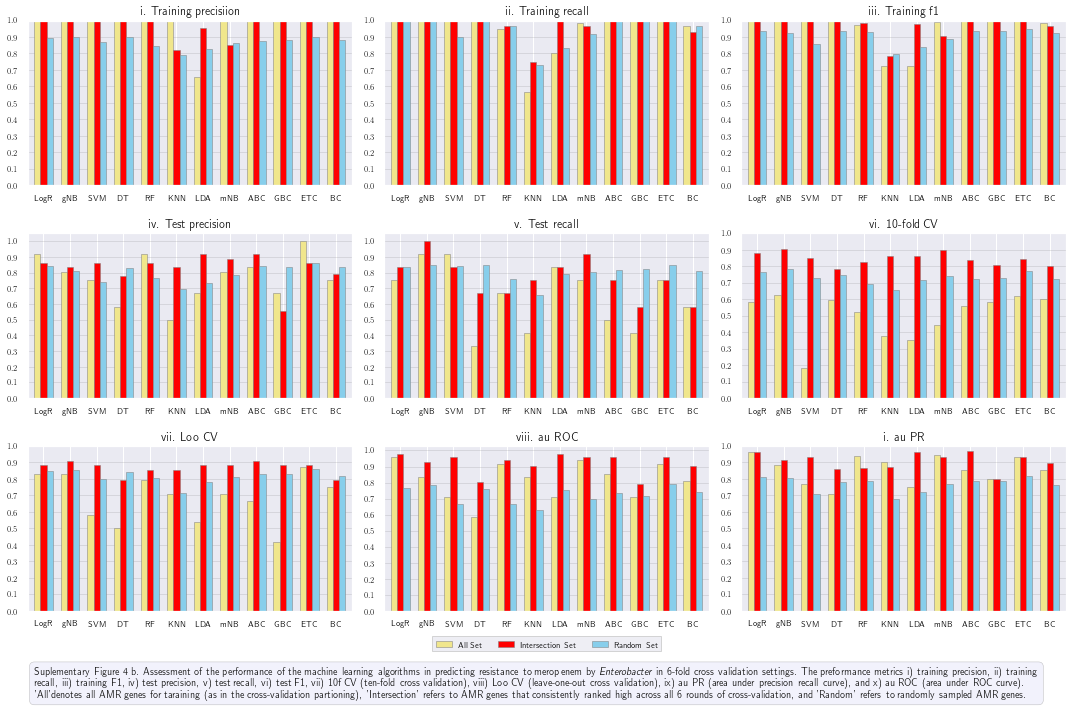

In [43]:
#All set, Intersection set and Random set performance for Enterobacter

#Dictionary of antibiotics
antb_SN = {'imipenem': '4 a', 'meropenem': '4 b'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Pseudomonas aeruginosa
    bacteria = 'Enterobacter'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Enterobacter}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    resistant = data_.loc[data_[antb] == 1]
    no_of= len(resistant.index)
    
    #Select equal number of resistant dataset
    susceptible = data_.loc[data_[antb] == 0].sample(n=no_of, random_state=42)
       
   #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

All Set Results gentamicin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.944,0.933,0.938,0.844,0.973,0.976,0.940
1,gNB,1.000,1.000,1.000,0.812,0.933,0.868,0.590,0.857,0.889,0.863
2,SVM,0.943,0.846,0.892,0.894,0.802,0.838,0.271,0.934,0.927,0.824
3,DT,1.000,1.000,1.000,0.967,0.890,0.922,0.880,0.929,0.956,0.956
4,RF,1.000,0.985,0.992,0.869,0.801,0.829,0.764,0.928,0.935,0.890
5,KNN,0.904,0.808,0.854,0.872,0.736,0.797,0.562,0.884,0.897,0.808
6,LDA,0.840,0.855,0.847,0.830,0.769,0.793,0.390,0.864,0.862,0.797
7,mNB,0.874,0.919,0.896,0.811,0.845,0.827,0.281,0.859,0.876,0.819
8,ABC,1.000,1.000,1.000,0.990,0.956,0.972,0.908,0.998,0.998,0.967
9,GBC,1.000,1.000,1.000,0.990,0.944,0.963,0.889,0.994,0.995,0.967


Intersection Set Results gentamicin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.995,0.965,0.980,0.954,0.912,0.931,0.965,0.985,0.971,0.978
1,gNB,0.715,0.982,0.827,0.704,0.967,0.812,0.919,0.959,0.879,0.918
2,SVM,0.988,0.958,0.973,0.947,0.923,0.933,0.944,0.988,0.973,0.978
3,DT,1.000,1.000,1.000,0.925,0.856,0.884,0.955,0.921,0.902,0.974
4,RF,0.998,0.972,0.985,0.954,0.878,0.912,0.954,0.978,0.959,0.973
5,KNN,0.965,0.835,0.895,0.961,0.779,0.853,0.937,0.950,0.932,0.960
6,LDA,0.987,0.969,0.978,0.920,0.890,0.901,0.948,0.945,0.917,0.965
7,mNB,0.664,0.921,0.772,0.661,0.912,0.766,0.901,0.957,0.905,0.907
8,ABC,1.000,0.998,0.999,0.910,0.901,0.898,0.962,0.978,0.954,0.973
9,GBC,1.000,1.000,1.000,0.960,0.878,0.908,0.963,0.982,0.966,0.978


Random Set Results gentamicin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.709,0.806,0.712,0.680,0.686,0.629,0.660,0.686,0.668,0.663
1,gNB,0.680,0.198,0.628,0.487,0.432,0.442,0.532,0.555,0.452,0.513
2,SVM,0.675,0.750,0.669,0.660,0.639,0.626,0.641,0.652,0.617,0.639
3,DT,0.766,0.864,0.774,0.735,0.744,0.677,0.691,0.734,0.706,0.696
4,RF,0.759,0.888,0.768,0.729,0.749,0.676,0.694,0.734,0.698,0.699
5,KNN,0.715,0.879,0.674,0.673,0.807,0.605,0.707,0.710,0.654,0.641
6,LDA,0.725,0.890,0.733,0.690,0.708,0.632,0.668,0.702,0.668,0.674
7,mNB,0.694,0.760,0.692,0.674,0.689,0.637,0.653,0.675,0.654,0.648
8,ABC,0.718,0.893,0.726,0.686,0.700,0.630,0.661,0.694,0.668,0.667
9,GBC,0.744,0.899,0.754,0.705,0.726,0.650,0.684,0.720,0.678,0.692


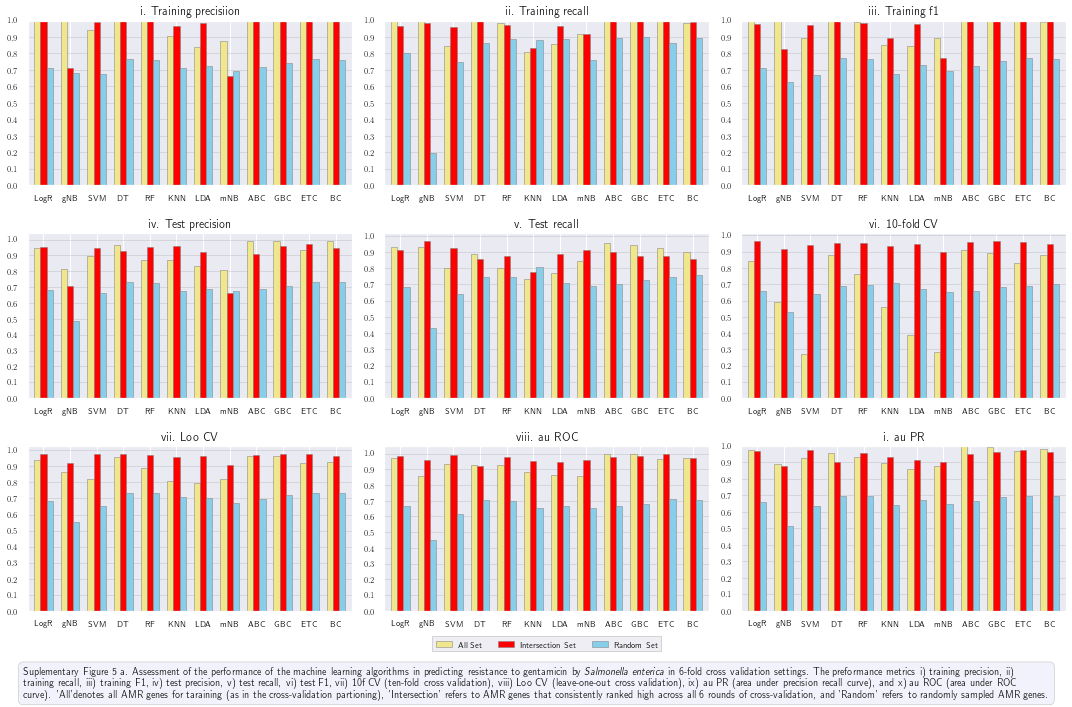

All Set Results kanamycin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.824,0.795,0.808,0.645,0.890,0.898,0.831
1,gNB,1.000,1.000,1.000,0.798,0.736,0.763,0.545,0.784,0.836,0.706
2,SVM,0.781,0.774,0.777,0.743,0.750,0.745,0.238,0.822,0.845,0.743
3,DT,1.000,1.000,1.000,0.972,0.910,0.937,0.848,0.940,0.963,0.941
4,RF,1.000,0.970,0.985,0.820,0.735,0.770,0.599,0.869,0.878,0.809
5,KNN,0.848,0.800,0.823,0.783,0.737,0.750,0.492,0.824,0.846,0.801
6,LDA,0.761,0.832,0.795,0.720,0.780,0.749,0.417,0.815,0.827,0.735
7,mNB,0.758,0.791,0.774,0.729,0.779,0.752,0.240,0.758,0.805,0.743
8,ABC,1.000,1.000,1.000,0.971,0.941,0.954,0.848,0.974,0.977,0.949
9,GBC,1.000,1.000,1.000,0.970,0.910,0.938,0.848,0.977,0.984,0.956


Intersection Set Results kanamycin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,0.927,0.962,0.942,0.824,0.874,0.936,0.986,0.960,0.976
1,gNB,0.164,1.000,0.282,0.163,1.000,0.281,0.359,0.678,0.595,0.329
2,SVM,0.991,0.932,0.961,0.966,0.751,0.839,0.900,0.981,0.947,0.966
3,DT,1.000,1.000,1.000,0.888,0.899,0.890,0.968,0.941,0.900,0.976
4,RF,1.000,0.985,0.993,0.971,0.826,0.885,0.930,0.966,0.929,0.949
5,KNN,0.878,0.756,0.812,0.783,0.649,0.696,0.872,0.927,0.826,0.929
6,LDA,0.987,0.932,0.959,0.938,0.853,0.893,0.970,0.978,0.947,0.974
7,mNB,0.490,0.862,0.625,0.478,0.823,0.603,0.847,0.942,0.728,0.852
8,ABC,1.000,1.000,1.000,0.927,0.868,0.895,0.955,0.986,0.966,0.976
9,GBC,1.000,1.000,1.000,0.971,0.913,0.940,0.977,0.972,0.959,0.983


Random Set Results kanamycin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.715,0.820,0.722,0.684,0.687,0.678,0.665,0.692,0.692,0.673
1,gNB,0.698,0.997,0.655,0.522,0.476,0.427,0.545,0.579,0.485,0.530
2,SVM,0.688,0.747,0.683,0.680,0.651,0.683,0.647,0.662,0.676,0.644
3,DT,0.775,0.926,0.787,0.718,0.723,0.683,0.681,0.732,0.706,0.695
4,RF,0.769,0.927,0.776,0.721,0.754,0.677,0.694,0.738,0.710,0.696
5,KNN,0.717,0.912,0.682,0.670,0.798,0.642,0.703,0.710,0.686,0.645
6,LDA,0.738,0.835,0.740,0.692,0.713,0.683,0.673,0.708,0.688,0.674
7,mNB,0.685,0.726,0.697,0.671,0.633,0.656,0.625,0.656,0.657,0.643
8,ABC,0.730,0.844,0.737,0.678,0.708,0.660,0.668,0.703,0.680,0.674
9,GBC,0.758,0.921,0.770,0.712,0.717,0.677,0.679,0.723,0.697,0.692


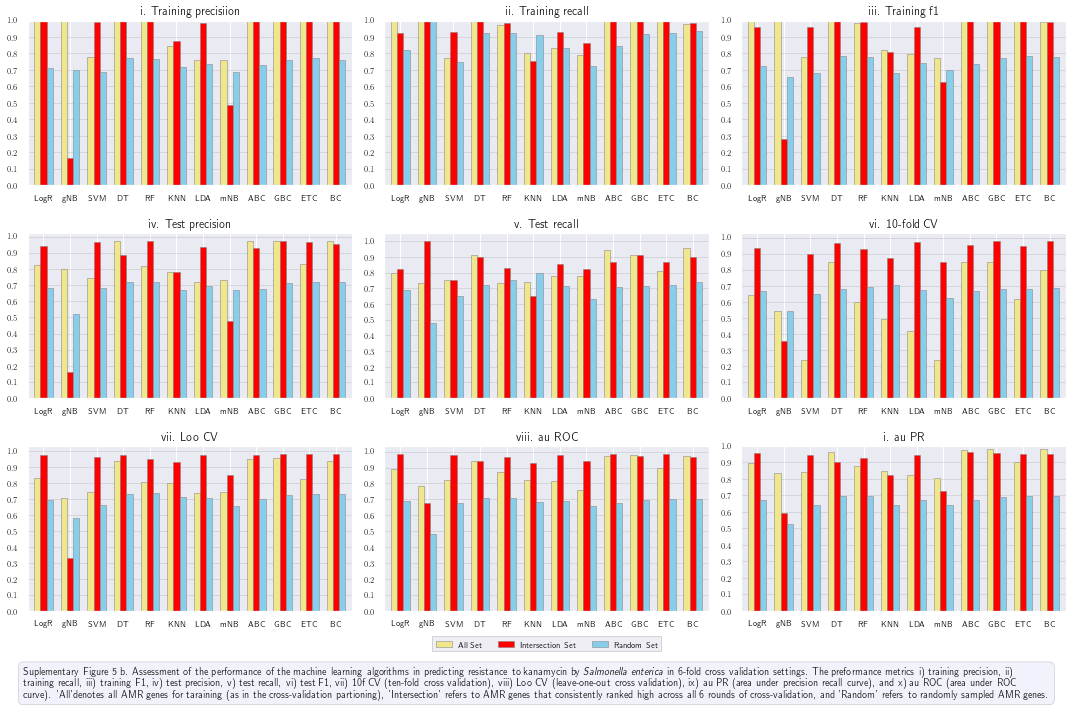

All Set Results streptomycin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,1.000,1.000,1.000,0.898,0.914,0.905,0.807,0.967,0.958,0.914
1,gNB,1.000,1.000,1.000,0.724,0.790,0.754,0.581,0.748,0.811,0.779
2,SVM,0.905,0.851,0.877,0.857,0.767,0.808,0.377,0.922,0.918,0.833
3,DT,1.000,1.000,1.000,0.976,0.971,0.974,0.939,0.974,0.981,0.979
4,RF,0.997,0.996,0.996,0.889,0.876,0.881,0.745,0.951,0.947,0.876
5,KNN,0.910,0.842,0.874,0.862,0.771,0.814,0.666,0.896,0.908,0.840
6,LDA,0.823,0.803,0.813,0.849,0.753,0.796,0.464,0.886,0.889,0.814
7,mNB,0.901,0.821,0.859,0.848,0.752,0.796,0.457,0.836,0.857,0.819
8,ABC,1.000,1.000,1.000,0.954,0.957,0.954,0.918,0.970,0.974,0.957
9,GBC,1.000,1.000,1.000,0.950,0.981,0.965,0.945,0.987,0.978,0.969


Intersection Set Results streptomycin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,au_ROC_avg,au_PR_avg,Loo_CV
0,LogR,0.962,0.981,0.971,0.943,0.943,0.943,0.942,0.989,0.976,0.957
1,gNB,0.895,0.914,0.904,0.895,0.924,0.907,0.922,0.962,0.944,0.925
2,SVM,0.937,0.981,0.958,0.906,0.933,0.918,0.924,0.986,0.971,0.937
3,DT,0.995,0.974,0.985,0.971,0.919,0.944,0.941,0.963,0.967,0.940
4,RF,0.982,0.987,0.984,0.930,0.914,0.921,0.930,0.981,0.967,0.938
5,KNN,0.929,0.906,0.917,0.923,0.843,0.880,0.897,0.954,0.932,0.924
6,LDA,0.958,0.991,0.974,0.942,0.924,0.932,0.950,0.992,0.986,0.953
7,mNB,0.908,0.892,0.900,0.899,0.876,0.884,0.903,0.965,0.945,0.901
8,ABC,0.973,0.977,0.975,0.940,0.952,0.946,0.954,0.983,0.959,0.955
9,GBC,0.983,0.986,0.984,0.958,0.957,0.957,0.954,0.988,0.980,0.965


Random Set Results streptomycin Salmonella


,classifier,tr_precision_avg,tr_recall_avg,tr_f1_avg,te_precision_avg,te_recall_avg,te_f1_avg,Tf_CV_Avg,Loo_CV_Avg,au_ROC_avg,au_PR_avg
0,LogR,0.702,0.845,0.695,0.671,0.704,0.664,0.676,0.689,0.668,0.665
1,gNB,0.691,0.713,0.617,0.601,0.680,0.553,0.643,0.638,0.591,0.557
2,SVM,0.678,0.744,0.672,0.667,0.648,0.651,0.644,0.656,0.655,0.640
3,DT,0.759,0.880,0.759,0.726,0.753,0.696,0.713,0.739,0.710,0.708
4,RF,0.757,0.888,0.753,0.727,0.765,0.689,0.718,0.740,0.720,0.707
5,KNN,0.719,0.944,0.667,0.678,0.831,0.602,0.732,0.721,0.687,0.651
6,LDA,0.701,0.858,0.701,0.646,0.700,0.642,0.672,0.689,0.644,0.669
7,mNB,0.664,0.735,0.662,0.636,0.650,0.614,0.633,0.648,0.634,0.631
8,ABC,0.695,0.849,0.695,0.668,0.688,0.650,0.664,0.681,0.658,0.662
9,GBC,0.743,0.895,0.741,0.700,0.718,0.674,0.694,0.718,0.677,0.692


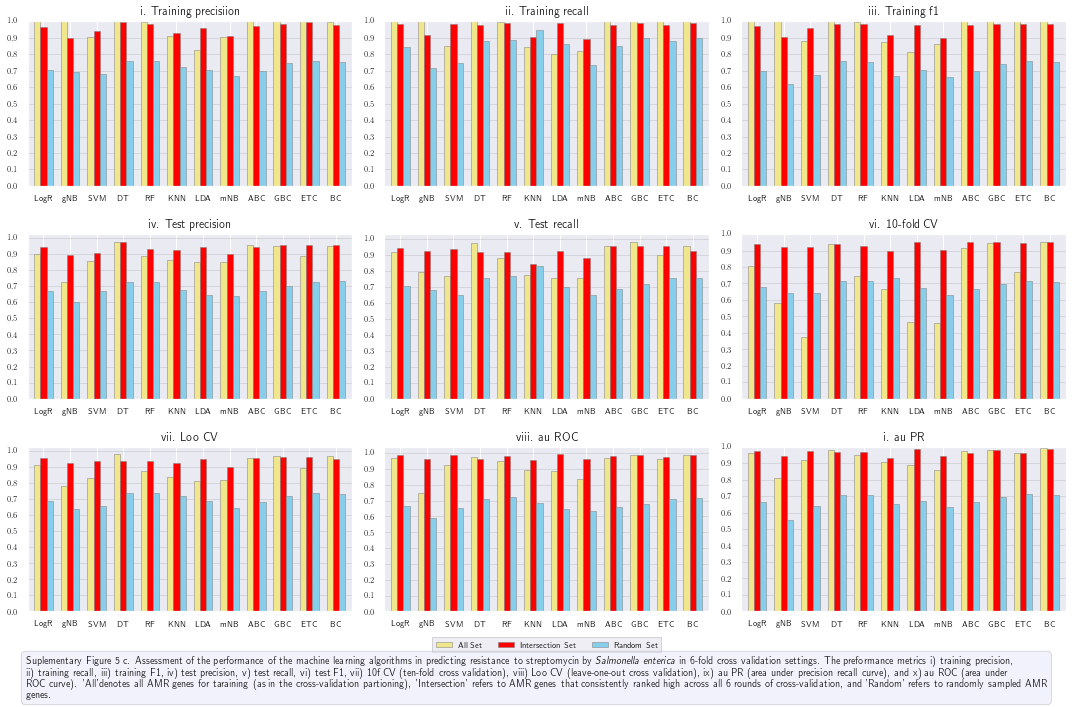

In [44]:
#All set, Intersection set and Random set performance for Salmonella entrica

#Dictionary of antibiotics
antb_SN = {'gentamicin': '5 a', 'kanamycin': '5 b', 'streptomycin': '5 c'}

#import pandas
import pandas as pd

for antb, SN in antb_SN.items():
    
    #Acronym for Pseudomonas aeruginosa
    bacteria = 'Salmonella'
    
    #Italicized full name bacteria for fig output
    italic_name = r"\textit{Salmonella enterica}"
    
    #Figure plot number
    supplementary_fig_no = SN
    
    #Import gene-ast data from github repository
    file_name = f'https://github.com/Janaksunuwar/AMRprediction_HomologyModeling_Docking/raw/main/Data/Final_Gene_AST_matrix_{bacteria}_{antb}_qc70_pi30.csv'

    #no of validation
    validation_no = 6
    
    #Result out
    file_all_out = f"{bacteria}_{antb}_Complete_Results_{validation_no}-fold_CV.csv"
    
    #read the gene-ast data
    data_ = pd.read_csv(file_name)
    
    #Put all the susceptible class in a separate dataset
    resistant = data_.loc[data_[antb] == 1]
    no_of= len(resistant.index)
    
    #Select equal number of resistant dataset
    susceptible = data_.loc[data_[antb] == 0].sample(n=no_of, random_state=42)
       
   #Concatenate both dataframes again
    data = pd.concat([resistant, susceptible])
    
    ML_Run()

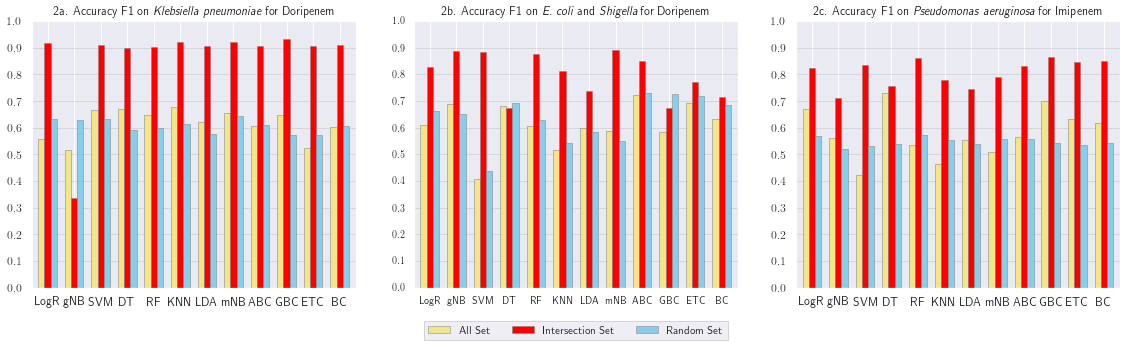

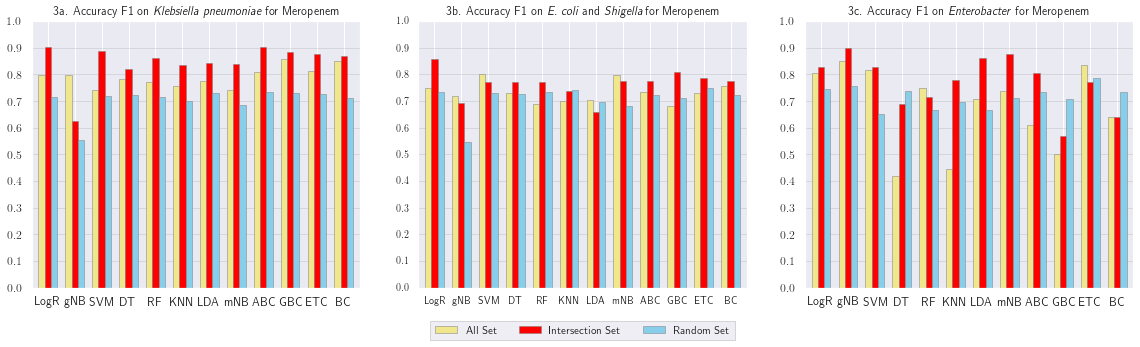

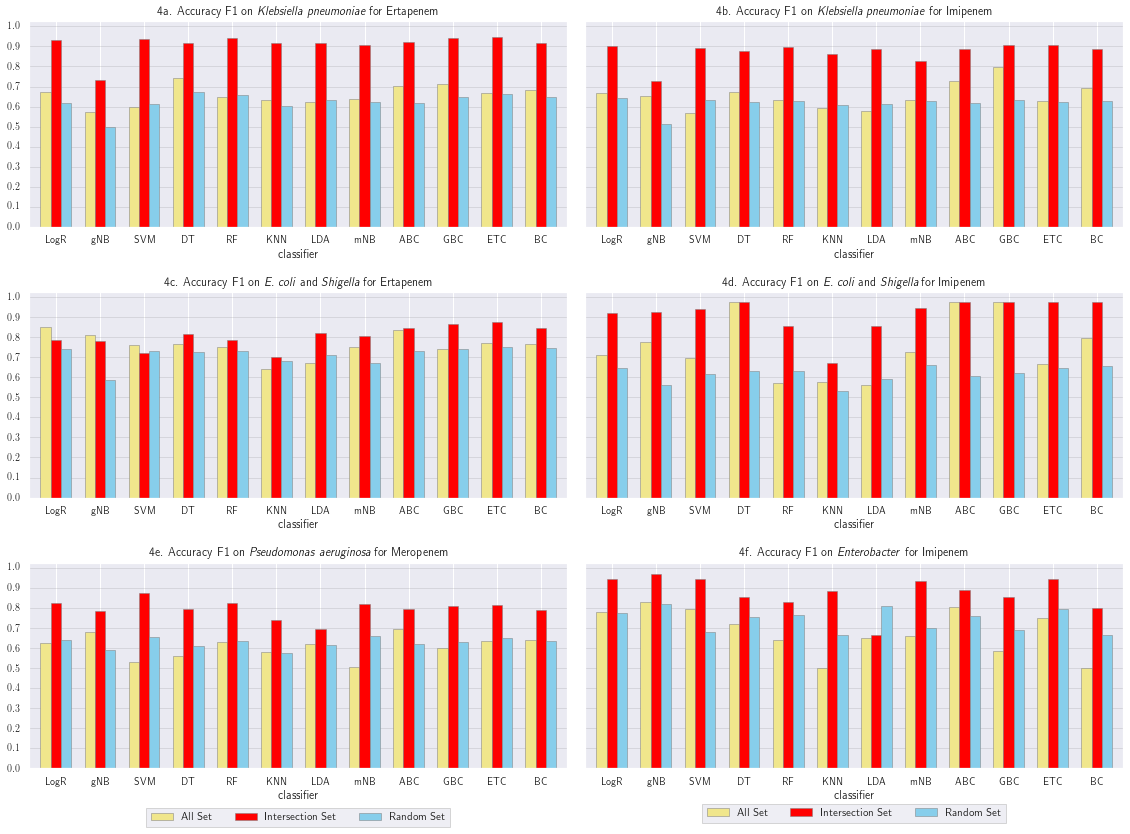

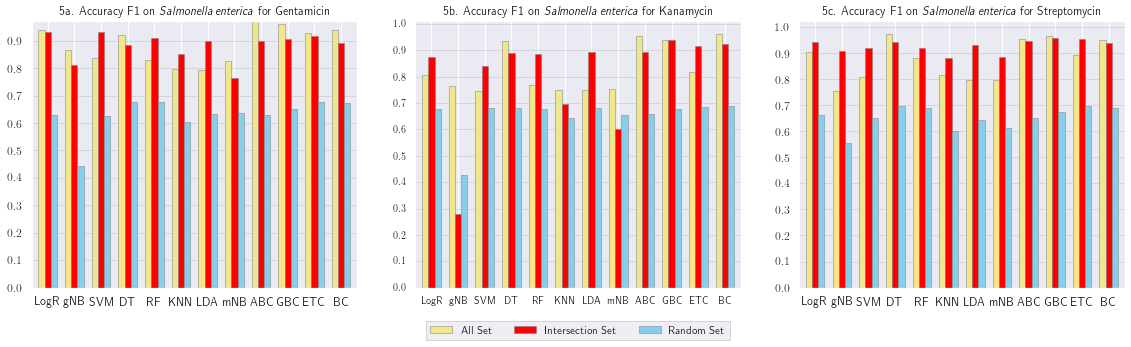

In [72]:
#Plot Figure 2, Figure 3, Figure 4, and Figure 5

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rc

#Activate latex text rendering
rc('text', usetex=True)

#Italic bacterial names for figures
it1 = r"\textit{Klebsiella pneumoniae}"
it2 = r"\textit{E. coli}"
it2_ = r"\textit{Shigella}"
it3 = r"\textit{Pseudomonas aeruginosa}"
it4 = r"\textit{Enterobacter}"
it5 = r"\textit{Salmonella enterica}"

# vlidation number
val_no = 6

#Open files for figure 2
d1 = pd.read_csv(f'Klebsiella_doripenem_F1_comparision_{val_no}-fold_CV.csv')
d1.set_index(['classifier'], inplace=True)
d2 = pd.read_csv(f'EcS_doripenem_F1_comparision_{val_no}-fold_CV.csv')
d2.set_index(['classifier'], inplace=True)
d3 = pd.read_csv(f'Pseudomonas_imipenem_F1_comparision_{val_no}-fold_CV.csv')
d3.set_index(['classifier'], inplace=True)

#Bar colors and set name
my_colors=['khaki', 'red', 'skyblue']
my_labels = ['All Set', 'Intersection Set', 'Random Set']

#Subplots for figure 2
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16,5))
plt.xlabel("")

ax1 = d1.plot(kind='bar', ax=axes[0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"2a. Accuracy F1 on {it1} for Doripenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax1.set_xlabel('')
ax1.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax1.set_axisbelow(True)

ax2= d2.plot(kind='bar', ax=axes[1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"2b. Accuracy F1 on {it2} and {it2_} for Doripenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax2.set_xlabel('')
ax2.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax2.set_axisbelow(True)
ax2.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.2),
           fancybox=False, shadow=False, prop={'size': 11})
ax2.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax2.set_axisbelow(True)

ax3= d3.plot(kind='bar', ax=axes[2], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"2c. Accuracy F1 on {it3} for Imipenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax3.set_xlabel('')
ax3.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax3.set_axisbelow(True)

fig.tight_layout()
plt.show()

fig.savefig(f'Figure2_gene_level.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})


#Open files for figure 3
d1j = pd.read_csv(f'Klebsiella_meropenem_F1_comparision_{val_no}-fold_CV.csv')
d1j.set_index(['classifier'], inplace=True)
d2j = pd.read_csv(f'EcS_meropenem_F1_comparision_{val_no}-fold_CV.csv')
d2j.set_index(['classifier'], inplace=True)
d3j = pd.read_csv(f'Enterobacter_meropenem_F1_comparision_{val_no}-fold_CV.csv')
d3j.set_index(['classifier'], inplace=True)

#Bar colors and set name
my_colors=['khaki', 'red', 'skyblue']
my_labels = ['All Set', 'Intersection Set', 'Random Set']

#Subplots for figure 3
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16,5))
plt.xlabel("")

ax1 = d1j.plot(kind='bar', ax=axes[0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"3a. Accuracy F1 on {it1} for Meropenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax1.set_xlabel('')
ax1.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax1.set_axisbelow(True)

ax2= d2j.plot(kind='bar', ax=axes[1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"3b. Accuracy F1 on {it2} and {it2_} for Meropenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax2.set_xlabel('')
ax2.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax2.set_axisbelow(True)
ax2.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.2),
           fancybox=False, shadow=False, prop={'size': 11})
ax2.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax2.set_axisbelow(True)

ax3= d3j.plot(kind='bar', ax=axes[2], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"3c. Accuracy F1 on {it4} for Meropenem", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax3.set_xlabel('')
ax3.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax3.set_axisbelow(True)

fig.tight_layout()
plt.show()

fig.savefig(f'Figure3_gene_level.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

#Open files for figure 4
d4 = pd.read_csv(f'Klebsiella_ertapenem_F1_comparision_{val_no}-fold_CV.csv')
d4.set_index(['classifier'], inplace=True)
d5 = pd.read_csv(f'Klebsiella_imipenem_F1_comparision_{val_no}-fold_CV.csv')
d5.set_index(['classifier'], inplace=True)
d6 = pd.read_csv(f'EcS_ertapenem_F1_comparision_{val_no}-fold_CV.csv')
d6.set_index(['classifier'], inplace=True)
d7 = pd.read_csv(f'EcS_imipenem_F1_comparision_{val_no}-fold_CV.csv')
d7.set_index(['classifier'], inplace=True)
d8 = pd.read_csv(f'Pseudomonas_meropenem_F1_comparision_{val_no}-fold_CV.csv')
d8.set_index(['classifier'], inplace=True)
d9 = pd.read_csv(f'Enterobacter_imipenem_F1_comparision_{val_no}-fold_CV.csv')
d9.set_index(['classifier'], inplace=True)

#Subplots for figure 4
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=True, figsize=(16,12))
plt.xlabel("")

ax4 = d4.plot(kind='bar', ax=axes[0,0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4a. Accuracy F1 on {it1} for Ertapenem",
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax4.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax4.set_axisbelow(True)

ax5= d5.plot(kind='bar', ax=axes[0,1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4b. Accuracy F1 on {it1} for Imipenem",
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax5.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax5.set_axisbelow(True)

ax6= d6.plot(kind='bar', ax=axes[1,0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4c. Accuracy F1 on {it2} and {it2_} for Ertapenem",
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax6.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax6.set_axisbelow(True)

ax7= d7.plot(kind='bar', ax=axes[1,1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4d. Accuracy F1 on {it2} and {it2_} for Imipenem",
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)

ax7.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax7.set_axisbelow(True)

ax8= d8.plot(kind='bar', ax=axes[2,0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4e. Accuracy F1 on {it3} for Meropenem",
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0, label=my_labels)
ax8.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.29),
           fancybox=False, shadow=False, prop={'size': 11})
ax8.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)


ax9= d9.plot(kind='bar', ax=axes[2,1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"4f. Accuracy F1 on {it4} for Imipenem",
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0, label=my_labels)
ax9.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax9.set_axisbelow(True)
ax9.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.27),
           fancybox=False, shadow=False, prop={'size': 11})

plt.subplots_adjust(top = 0.97, bottom=0.0, hspace=0.29, wspace=0.05 )
fig.tight_layout(pad=1.5)
plt.show()

fig.savefig(f'Fig4_gene_level.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

#Open files for figure 5
d10 = pd.read_csv(f'Salmonella_gentamicin_F1_comparision_{val_no}-fold_CV.csv')
d10.set_index(['classifier'], inplace=True)
d11 = pd.read_csv(f'Salmonella_kanamycin_F1_comparision_{val_no}-fold_CV.csv')
d11.set_index(['classifier'], inplace=True)
d12 = pd.read_csv(f'Salmonella_streptomycin_F1_comparision_{val_no}-fold_CV.csv')
d12.set_index(['classifier'], inplace=True)

#Subplots for figure 5
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(16,5))
plt.xlabel("")


ax10 = d10.plot(kind='bar', ax=axes[0], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"5a. Accuracy F1 on {it5} for Gentamicin", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax10.set_xlabel('')
ax10.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax10.set_axisbelow(True)
ax10.margins(0)

ax11= d11.plot(kind='bar', ax=axes[1], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"5b. Accuracy F1 on {it5} for Kanamycin", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=10, rot=0)
ax11.set_xlabel('')
ax11.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax11.set_axisbelow(True)
ax11.legend(labels=my_labels, loc='lower center', borderaxespad=0.1, ncol=3,
           bbox_to_anchor=(0.5, -0.2),
           fancybox=False, shadow=False, prop={'size': 11})
ax11.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax11.set_axisbelow(True)

ax12= d12.plot(kind='bar', ax=axes[2], color=my_colors, width = 0.7, edgecolor='grey', 
         linewidth=0.5, title =f"5c. Accuracy F1 on {it5} for Streptomycin", 
         legend=False, yticks = np.arange(0,1.1, step=0.1),
         fontsize=12, rot=0)
ax12.set_xlabel('')
ax12.grid(linestyle='-', color ='#666666', axis='y', alpha=0.3, lw=0.5)
ax12.set_axisbelow(True)

fig.tight_layout()
plt.show()

fig.savefig(f'Fig5_gene_level.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})


In [82]:
#The set of consistent genes in all rounds of cross validation
import pandas as pd
import numpy as np
import os

def Table():
    All_HP_Lookup = pd.read_csv(f'{bact}_All_Hypothetical_Protein_Lookup.csv')
    table = pd.DataFrame(columns=[])
    for antb in antibios:
        #open the consistent genes
        cg_df = pd.read_csv(f'{bact}_{antb}_Consistent_Genes_Per_6-fold_CV.csv')
        #rename the column head Feature to match for merge
        cg_df = cg_df.rename(columns={'Feature': 'match'})
        #merge to keep only HP proteins from consistent genes and find accession number
        test = pd.merge(All_HP_Lookup, cg_df, on='match', how='inner', indicator=True)
        #remove the duplicate accession numbers
        test1 = test.drop_duplicates(subset=['non-redundant_refseq'])
        #have specific columns only
        consistent_lookedUp = test1[['assembly','non-redundant_refseq', 'name', 'match']].reset_index(drop=True)
        #Consistent genes for the publication table where all HP are replaced
        consistent_lookedUp_for_table = consistent_lookedUp.drop_duplicates(subset=['match']).reset_index(drop=True)
        #select only the name
        consistent_lookedUp_for_table_name_only = consistent_lookedUp_for_table[['non-redundant_refseq', 'name',]]
        d1 = consistent_lookedUp_for_table_name_only.rename(columns={'non-redundant_refseq': 'accession', 'name': f'{antb}'})
        table = pd.concat([table, d1], axis=1)
    #export to csv
    table.to_csv(f'{bact}_consistent_genes_gene_level.csv')
    print(f'Putative consistent genes responsible for resistance in {bact}')
    display(table.head(10))

#For Klebsiella pneumoniae
bact = 'Klebsiella'
antibios = ['doripenem', 'ertapenem', 'imipenem', 'meropenem']   
Table()

#For E.coli and Shigella
bact = 'EcS'
antibios = ['doripenem', 'ertapenem', 'imipenem', 'meropenem']   
Table()

#For Pseudomonas aeruginosa
bact = 'Pseudomonas'
antibios = ['imipenem', 'meropenem']   
Table()

#For Enterobacter
bact = 'Enterobacter'
antibios = ['imipenem', 'meropenem']   
Table()

#For Salmonella enterica
bact = 'Salmonella'
antibios = ['gentamicin', 'kanamycin', 'streptomycin']   
Table()


Putative consistent genes responsible for resistance in Klebsiella


,accession,doripenem,accession,ertapenem,accession,imipenem,accession,meropenem
0,WP_071579748.1,AlpA family phage regulatory protein,WP_040215863.1,"(2,3-dihydroxybenzoyl)adenylate synthase EntE",WP_038433285.1,DUF1833 family protein,WP_016338366.1,DUF2913 family protein
1,WP_064162551.1,Cu(+)/Ag(+) sensor histidine kinase,WP_016338366.1,DUF2913 family protein,WP_125297154.1,DUF2560 family protein,WP_064162443.1,DUF551 domain-containing protein
2,WP_004152355.1,DNA methylase,WP_000454193.1,DUF3330 domain-containing protein,WP_016338366.1,DUF2913 family protein,WP_071653259.1,DinB family protein
3,WP_125297154.1,DUF2560 family protein,WP_004171440.1,hypothetical protein,WP_002889795.1,GABA permease,WP_004152336.1,hypothetical protein
4,WP_004147125.1,hypothetical protein,WP_004151678.1,phosphodiester glycosidase family protein,WP_015060010.1,hypothetical protein,WP_013023807.1,hypothetical protein
5,WP_004888565.1,hypothetical protein,WP_004152347.1,hypothetical protein,WP_001568047.1,hypothetical protein,WP_064162286.1,hypothetical protein
6,WP_004153014.1,hypothetical protein,WP_000219391.1,Mph(A) family macrolide 2'-phosphotransferase,WP_013214013.1,hypothetical protein,WP_004152347.1,hypothetical protein
7,WP_032418371.1,arsenic transporter,WP_004141234.1,NAD(P)-binding domain-containing protein,WP_004152347.1,hypothetical protein,WP_004227314.1,hypothetical protein
8,WP_064162389.1,bifunctional phosphoribosyl-AMP cyclohydrolase...,WP_139153029.1,Tn3 family transposase,WP_023280305.1,hypothetical protein,WP_001067855.1,IS6-like element IS26 family transposase
9,WP_004152754.1,DNA polymerase III subunit theta,WP_016240610.1,TraM recognition domain-containing protein,WP_004178684.1,L-2-hydroxyglutarate oxidase,WP_001389365.1,IS6-like element IS6100 family transposase


Putative consistent genes responsible for resistance in EcS


,accession,doripenem,accession,ertapenem,accession,imipenem,accession,meropenem
0,WP_001526018.1,DUF2726 domain-containing protein,WP_001296350.1,6-phospho-beta-glucosidase BglA,WP_001296350.1,6-phospho-beta-glucosidase BglA,WP_001202894.1,GpE family phage tail protein
1,WP_000138550.1,DotI/IcmL/TraM family protein,WP_001053005.1,DNA base-flipping protein YbcN,WP_142438680.1,DotA/TraY family protein,WP_000183485.1,GyrI-like domain-containing protein
2,WP_001182900.1,toxin YdaT domain-containing protein,WP_000158908.1,DNA-packaging protein FI,WP_001066372.1,hypothetical protein,WP_001274833.1,hypothetical protein
3,WP_000209290.1,DUF262 domain-containing protein,WP_000651752.1,DUF1427 family protein,WP_000160349.1,multidrug efflux RND transporter periplasmic a...,WP_072178178.1,PerC family transcriptional regulator
4,WP_000702803.1,hypothetical protein,WP_001104802.1,DUF2300 domain-containing protein,WP_000431664.1,sugar-binding transcriptional regulator,WP_001240664.1,TonB-dependent siderophore receptor
5,WP_000912588.1,DUF2713 family protein,WP_001680836.1,hypothetical protein,WP_001296423.1,accessory factor UbiK family protein,WP_000431664.1,sugar-binding transcriptional regulator
6,WP_001147284.1,hypothetical protein,WP_000224914.1,hypothetical protein,WP_001295875.1,two-component system sensor histidine kinase KdbD,WP_000275542.1,tagatose bisphosphate family class II aldolase
7,WP_001333354.1,hypothetical protein,WP_000729638.1,hypothetical protein,WP_001293458.1,H-NS histone family protein,WP_000712316.1,DotU family type IV/VI secretion system protein
8,WP_001301824.1,fructoselysine 6-phosphate deglycase,WP_001274833.1,hypothetical protein,WP_000008707.1,hypothetical protein,WP_000564322.1,phosphate propanoyltransferase
9,WP_001299283.1,threonine-rich inner membrane protein GfcA,WP_001336239.1,hypothetical protein,WP_001262390.1,hypothetical protein,WP_000588536.1,DUF1643 domain-containing protein


Putative consistent genes responsible for resistance in Pseudomonas


,accession,imipenem,accession,meropenem
0,WP_003107098.1,DUF2285 domain-containing protein,WP_003101875.1,4-hydroxybenzoate transporter PcaK
1,WP_023098703.1,hypothetical protein,WP_024947973.1,7-cyano-7-deazaguanine synthase
2,WP_010791835.1,hypothetical protein,WP_016263382.1,DNA adenine methylase
3,WP_003110789.1,hypothetical protein,WP_023106765.1,hypothetical protein
4,WP_031652693.1,hypothetical protein,WP_031669819.1,hypothetical protein
5,WP_009681707.1,hypothetical protein,WP_003102715.1,hypothetical protein
6,WP_015649419.1,hypothetical protein,WP_124075009.1,hypothetical protein
7,WP_003103998.1,P-type conjugative transfer ATPase TrbB,WP_003140552.1,hypothetical protein
8,WP_003158124.1,P-type conjugative transfer protein TrbL,WP_003088911.1,hypothetical protein
9,WP_023107680.1,PHB depolymerase family esterase,WP_008567186.1,hypothetical protein


Putative consistent genes responsible for resistance in Enterobacter


,accession,imipenem,accession,meropenem
0,WP_023332543.1,30S ribosomal protein S12 methylthiotransferas...,WP_023332776.1,3-hydroxybutyrate dehydrogenase
1,WP_023332265.1,ATP-binding protein,WP_014884857.1,DTW domain-containing protein
2,WP_023331331.1,AlpA family phage regulatory protein,WP_072093713.1,DUF1097 domain-containing protein
3,WP_023331517.1,Cu(+)/Ag(+) efflux RND transporter outer membr...,WP_014883927.1,DUF3828 domain-containing protein
4,WP_023332598.1,DUF1983 domain-containing protein,WP_023150225.1,DUF4054 domain-containing protein
5,WP_023332009.1,DUF2184 domain-containing protein,WP_016063584.1,DUF4224 domain-containing protein
6,WP_014883748.1,DUF2878 domain-containing protein,WP_050595720.1,DUF4406 domain-containing protein
7,WP_023332015.1,DUF3277 family protein,WP_032629009.1,DsbA family protein
8,WP_014884187.1,DsrE family protein,WP_014884187.1,DsrE family protein
9,WP_023330425.1,hypothetical protein,WP_006808895.1,HNH nuclease family protein


Putative consistent genes responsible for resistance in Salmonella


,accession,gentamicin,accession,kanamycin,accession,streptomycin
0,WP_001125981.1,DUF2740 family protein,WP_001248406.1,DNA helicase,WP_077906512.1,DUF1983 domain-containing protein
1,WP_015675517.1,hypothetical protein,WP_001129708.1,DNA topoisomerase,WP_024132254.1,hypothetical protein
2,WP_000166966.1,hypothetical protein,WP_000036317.1,hypothetical protein,WP_000996122.1,cellulose biosynthesis protein BcsQ
3,WP_001111087.1,ash family protein,WP_000166966.1,hypothetical protein,WP_001064674.1,excinuclease Cho
4,WP_000268275.1,baseplate assembly protein,WP_000525755.1,N-acetylneuraminate epimerase,WP_000086147.1,DNA methylase
5,WP_001206316.1,ANT(3'')-Ia family aminoglycoside nucleotidylt...,WP_001041640.1,Rop family plasmid primer RNA-binding protein,WP_001348079.1,DUF1281 domain-containing protein
6,WP_000896475.1,DDE-type integrase/transposase/recombinase,WP_031611757.1,autotransporter adhesin BigA,WP_000274500.1,DUF1380 domain-containing protein
7,WP_000366823.1,DNA topoisomerase 3,WP_001030983.1,diguanylate cyclase DgcN,WP_000271705.1,DUF1380 family protein
8,WP_000274500.1,DUF1380 domain-containing protein,WP_000065276.1,excisionase family protein,WP_000454193.1,DUF3330 domain-containing protein
9,WP_000454193.1,DUF3330 domain-containing protein,WP_001113462.1,tail protein,WP_000698351.1,DotA/TraY family protein


### Example Homology Modeling of Klebsiella pneumonia for antibiotic Doripenem

From the accession of the list of the most important genes from the above framework is used to download the fasta amino acid file and then blasted against the RSCB protein database locally